# Diabetes Clustering Analysis



## 0. Imports

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from gower import gower_matrix
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

## 1. Introduction

The number of diabetic patients has been increasing in recent decades, which has brought great potential dangers to people's health. According to the report of the world health organization, diabetes is a major cause of blindness, kidney failure, heart attacks, stroke and lower limb amputation (WHO). And our research will show the impact of different body indicators on diabetes. The dataset we choose include several attributes, like BMI, Chol, TG and so on, we can obtain conclusions from different clusters through cluster analysis. As Dilts said in his report, by finding groups of patients with similar health risks, doctors can create better and more personalized plans for tests and treatments (Dilts). For the applicable groups of our research results, I think it is mainly targeted at some doctors and students studying medical care, as well as some people with bad living habits. For students, our results can tell them which factors have an important impact on diabetes, thus laying the foundation for them to learn more profound medical knowledge in the future. According to the research, lifestyle changes can reduce the onset of T2D by as much as 58% in high-risk subjects (European Commission). So for those people who have bad living habits, some of them may change their life style after they watch the result from our research.

A clustering where each cluster is well-separated:
Each cluster will represent patients with different causes, which also corresponds to different attributes in the dataset. With specific grouping, doctors can provide more targeted treatment to patients.

A clustering where at least one cluster was a singleton outlier.
Singleton outlier will have a great impact on the doctor's conclusion, because each value in the dataset has a normal interval, and if we see obvious abnormal values, it proves that one of the physical indicators is abnormal and requires a doctor pay much more attention on that

A fuzzy clustering
When a patient has multiple indicators outside the normal range, fuzzy cluster will have better results. Because the patient's disease may not caused by a single reason, but by multiple factors that may overlap, fuzzy cluster will perform better in this situation.

A dendrogram which displays a nested cluster relationship 
Dendrograms are useful when doctors determine the cause of a disease. For example, which indicator abnormality will have corresponding physical manifestations. At the same time, dendrogram can also show the impact of genetic factors on people, because diabetes also has genetic factors.

## 2. Dataset Discussion

### 2.1 Dataset Display

In [7]:
df = pd.read_csv("diabetes.csv")
df.head(5)

idx  Age Gender  BMI  Chol   TG  HDL  LDL    Cr  BUN  Diagnosis
0    0   50      F   24   4.2  0.9  2.4  1.4  46.0  4.7          0
1    1   26      M   23   3.7  1.4  1.1  2.1  62.0  4.5          0
2    2   33      M   21   4.9  1.0  0.8  2.0  46.0  7.1          0
3    3   45      F   21   2.9  1.0  1.0  1.5  24.0  2.3          0
4    4   50      F   24   3.6  1.3  0.9  2.1  50.0  2.0          0

In [8]:
df.shape

(5132, 11)

This dataset has 5132 rows (observations) before doing any data cleaning.

### 2.2 Dataset Source
We found this dataset from kaggle.   
Here is the link : https://www.kaggle.com/datasets/simaanjali/diabetes-classification-dataset  
We downloaded this dataset on 04/16/2024

### 2.3 Original Dataset Information

- We have 5132 rows and each row(observation) represents a patient's clinical information

- This dataset was collected from a number of patients that have been analyzed to examine cardiovascular health and kidney function.

- This dataset is inclusive of all possible types of observations that could have been considered in this dataset.

-  The comprehensiveness of the dataset could provide doctors and medical students with a thorough understanding of potential impacts of diabetes. For unhealthy people and patients, the comprehensiveness of the dataset could enable them identify others with similar health condition and foresee their likelihood of having diabetes based on the cluster analysis.

### 2.4 Selected Variables

- Age  : patient age in years, can be a risk factor for diabetes.

- Gender : M / F, indicates the gender of the patient. (categorical)

- BMI : a numerical measure that determine whether a person has normal weight, overweight, or obese.

- Chol : total cholesterol level in the blood (mg/dL).

- TG : types of fat found in the blood (mg/dL).

- HDL : good cholesterol that helps transport excess cholesterol from the body's tissues back to the liver for further processing or excretion (mg/dL). 

- LDL : bad cholesterol that can cause plaque buildup in the arteries, increasing the risk of heart disease and stroke  (mg/dL). 

- Cr : waste products of muscle metabolism that are excreted from the body through the kidneys  (mg/dL). 

- BUN : blood test to measure the amount of urea nitrogen in the blood  (mg/dL). 

## 3. Dataset Cleaning and Exploration

Before we move on, we need to do some dataset cleaning.

The original dataset contained a column named "idx" that was a duplicate of the original index, so we removed it.

In [9]:
df.drop(['idx'], axis=1, inplace=True)

Also, in the Gender column, we observe there are some rows with Gender = "f", this is because some female are recoreded as "f" (lower case), we need to transform them into "F"

In [10]:
df["Gender"].unique() # 'f'

array(['F', 'M', 'f'], dtype=object)

In [11]:
df['Gender'] = df['Gender'].replace('f', 'F')

Also, we can drop the pre-assigned label (diagnosis) and store it as df_data for further data exploration.

In [12]:
df_label = df["Diagnosis"]

In [13]:
df_data = df.drop(['Diagnosis'], axis=1)
df_data

Age Gender  BMI  Chol    TG   HDL   LDL    Cr   BUN
0      50      F   24  4.20  0.90  2.40  1.40  46.0  4.70
1      26      M   23  3.70  1.40  1.10  2.10  62.0  4.50
2      33      M   21  4.90  1.00  0.80  2.00  46.0  7.10
3      45      F   21  2.90  1.00  1.00  1.50  24.0  2.30
4      50      F   24  3.60  1.30  0.90  2.10  50.0  2.00
...   ...    ...  ...   ...   ...   ...   ...   ...   ...
5127   54      M   23  5.00  1.50  1.24  2.98  77.0  3.50
5128   50      F   22  4.37  2.09  1.37  2.29  47.3  4.40
5129   67      M   24  3.89  1.38  1.14  2.17  70.6  4.73
5130   60      F   29  5.91  1.29  1.73  2.85  50.2  7.33
5131   37      M   34  5.42  2.66  1.08  2.87  75.5  4.61

[5132 rows x 9 columns]

### 3.1 Missing Value Detection and Cleaning

In [14]:
df.isna().sum()

Age          0
Gender       0
BMI          0
Chol         0
TG           0
HDL          0
LDL          0
Cr           0
BUN          0
Diagnosis    0
dtype: int64

There are no missing values in our dataset, so there is no need to perform processing of missing values.

### 3.2 Outlier Identification - Two Variable Outliers

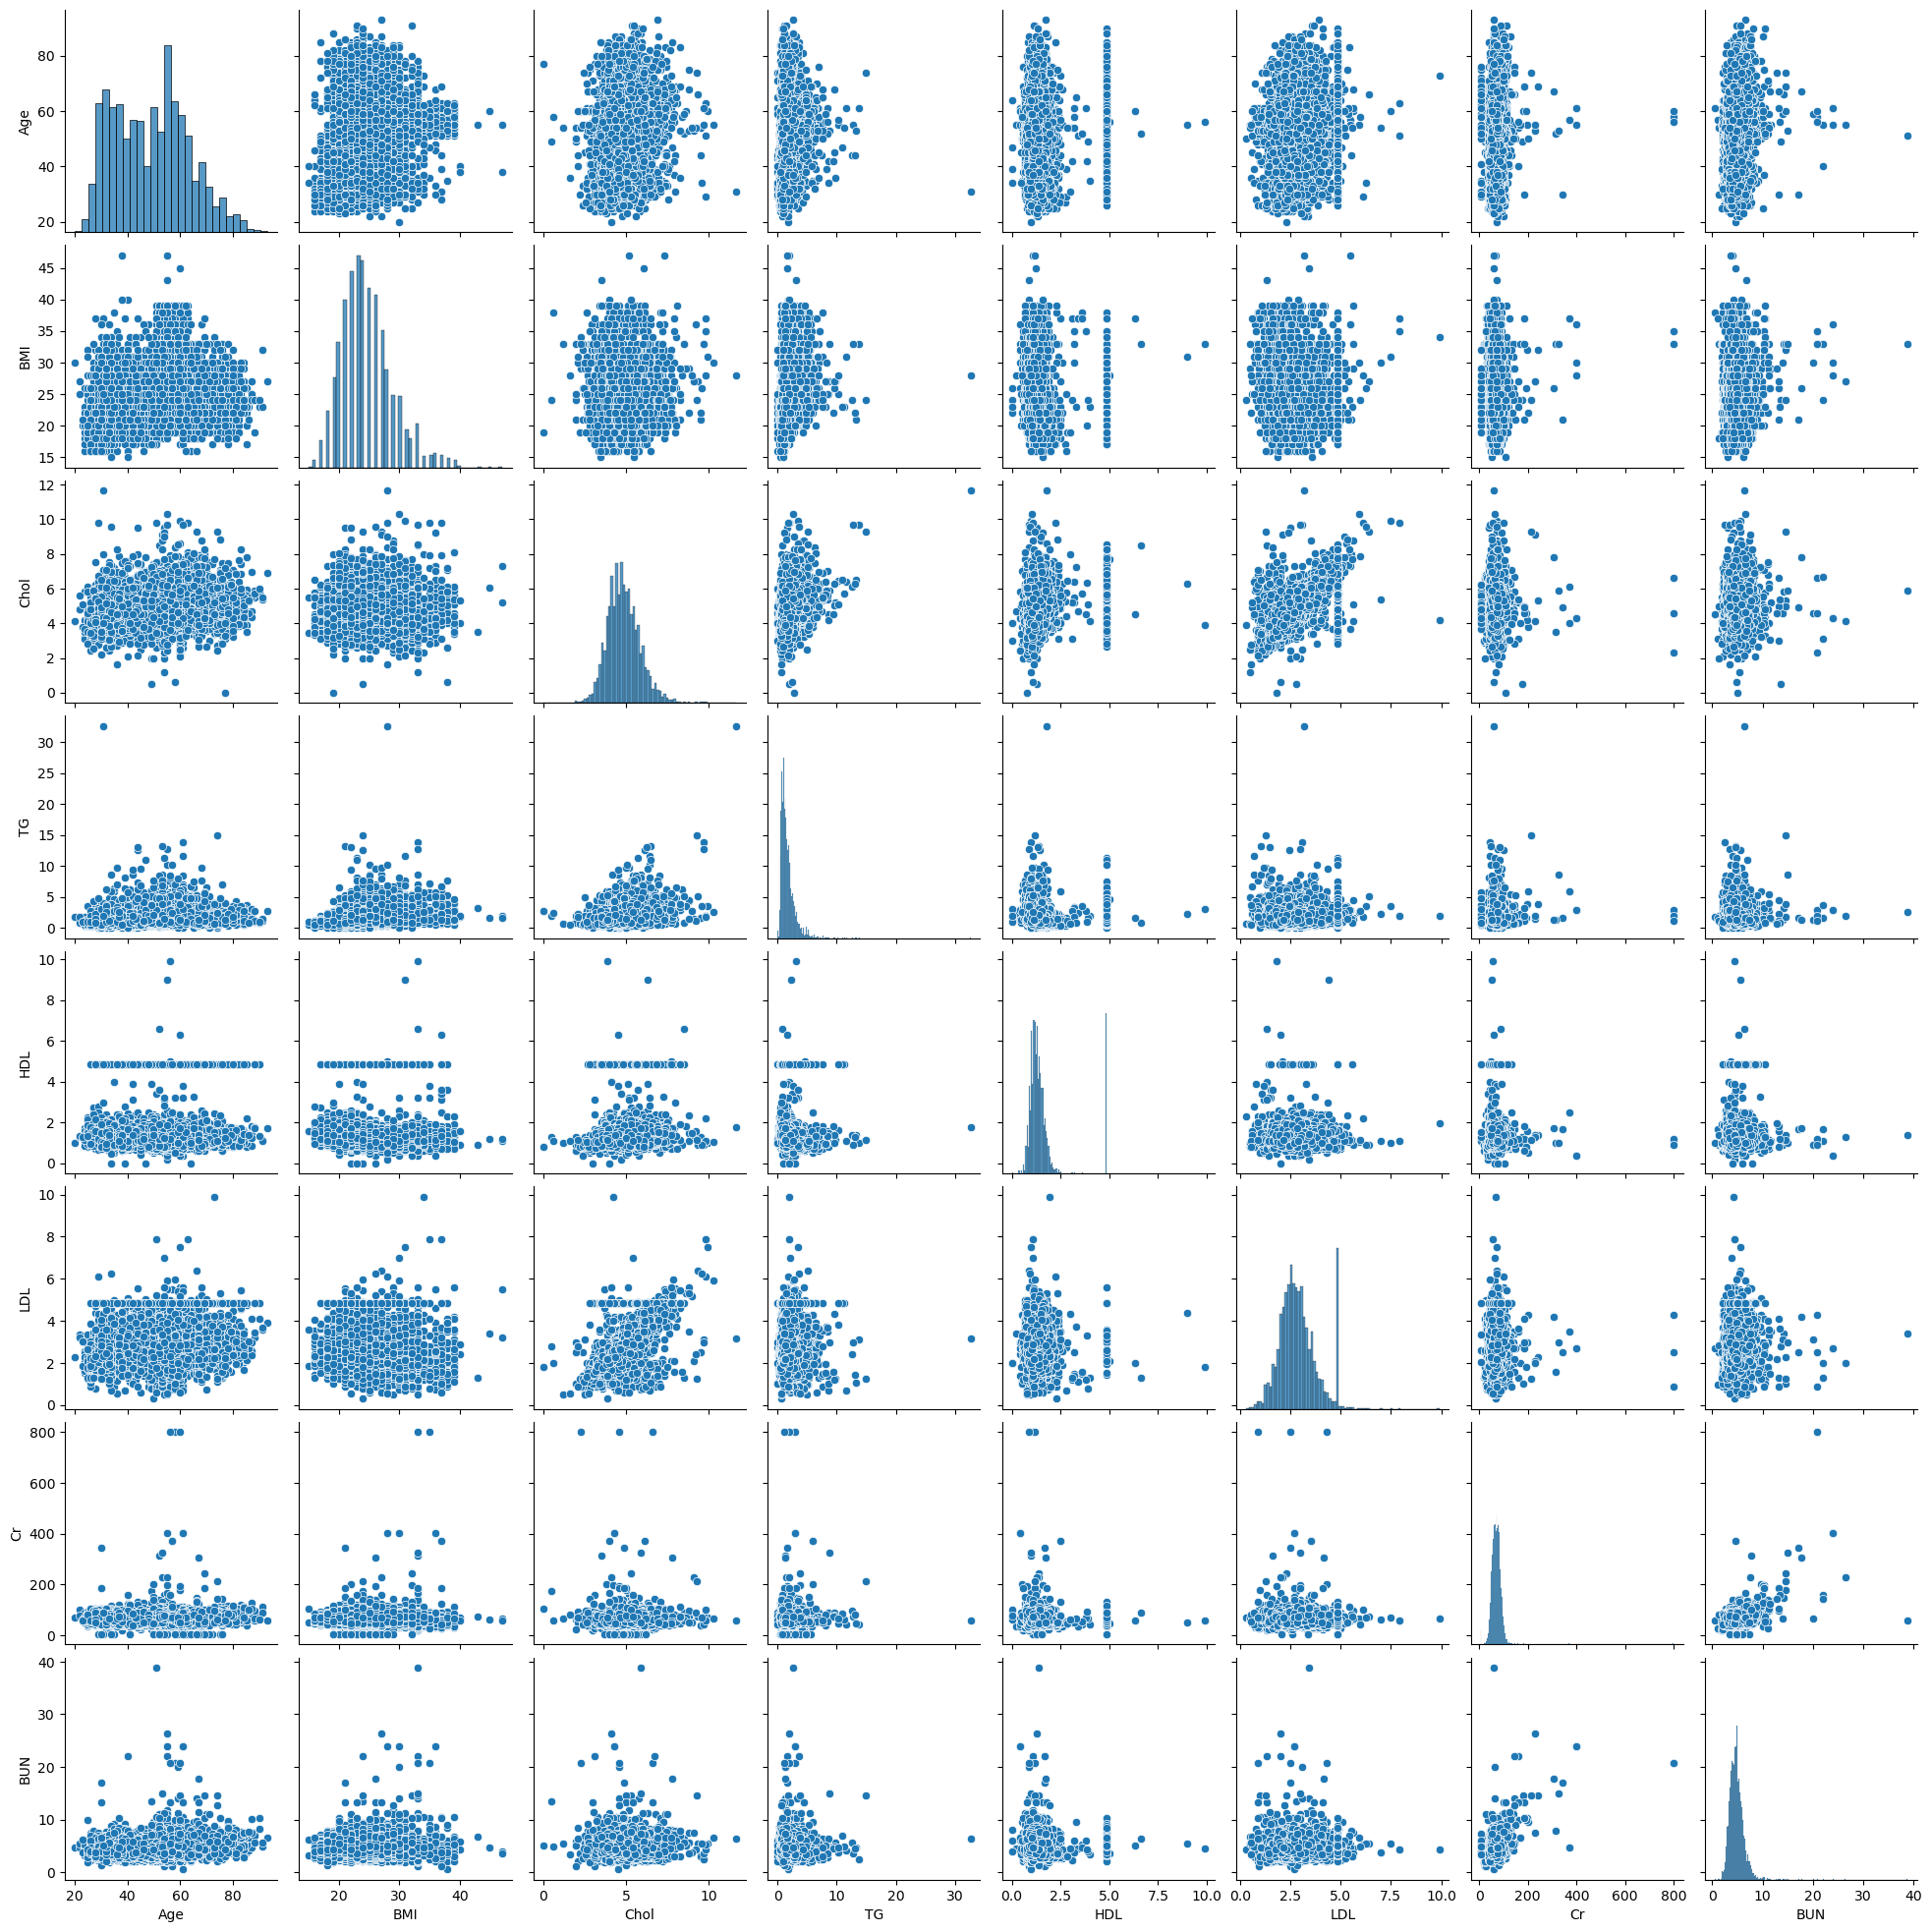

In [15]:
sns.pairplot(data=df_data)
plt.show()

By looking at the pair-wise scatterplot, we can observe some outiles:

- In the scatterplot of Age vs TG, there is an observation aged around 30 has a high TG level

- In the scatterplot of Age vs HDL, there are few observations whose ages are around 50 have a high level of HDL

- In the scatterplot of Age vs LDL, there is an observation aged around 60 has a high level of LDL

- In the scatterplot of Age vs Cr, there are few observations whose ages are around 50 have a high level of Cr

- In the scatterplot of Age vs BUN, there is an observation aged around 40 has a high BUN level

- In the scatterplot of BMI vs TG, there is an observation who has a middle level of BMI, has a high TG level

- In the scatterplot of BMI vs HDL, there are few observations who have a middel level of BMI, have a high HDL level

- In the scatterplot of BMI vs LDL, there are few observations who have a middle level of BMI, have a high LDL level

- In the scatterplot of BMI vs Cr, there are few observations who have a middle level of BMI, have a high Cr level

- In the scatterplot of BMI vs BUN, there is an observation who has a middle level of BMI, has a high BUN level

- In the scatterplot of Chol vs TG, there is an observation who has a high level of Chol, has a high TG level

- In the scatterplot of Chol vs HDL, there are few observations who have a middle level of Chol, have a high HDL level

- In the scatterplot of Chol vs LDL, there is an observation who has a middle level of Chol, has a high LDL level

- In the scatterplot of Chol vs Cr, there are few observations who have a middle-low level of Chol, have a high Cr level

- In the scatterplot of Chol vs BUN, there is an observation who has a middle level of Chol, has a high BUN level

- In the scatterplot of TG vs HDL, there is an observation who has a high level of TG, has a low HDL level

- In the scatterplot of TG vs LDL, there is an observation who has a high level of TG, has a low LDL level

- In the scatterplot of TG vs Cr, there is an observation who has a high level of TG, has a low Cr level, and few observations who have a low level of TG, have a high Cr level

- In the scatterplot of TG vs BUN, there is an observation who has a high level of TG, has a low BUN level, and an observation who has a low level of TG, has a high BUN level

- In the scatterplot of HDL vs LDL, there are few observations who have a high level of HDL, have a middle-low LDL level

- In the scatterplot of HDL vs Cr, there are few observations who have a high level of HDL, have a low Cr level, and few observations who havea low level of HDL, have a high Cr level

- In the scatterplot of HDL vs BUN, there are few observations who have a high level of HDL, have a low BUN level, and few observations who havea low level of HDL, have a high BUN level

- In the scatter plot of LDL vs Cr, there are few observations who have middle-low level of LDL, have a high Cr level

- In the scatterplot of LDL vs BUN, there is an observation who have middle level of LDL, have a high BUN level

- In the scatterplot of Cr vs BUN, there is an observation who has a high level of Cr, has a middle level of BUN, and an observation has low level of Cr, has a high level of BUN

### 3.3 Outlier Identification - 3+ Variable Outliers

To  identify outliers including those that can only be seen in higher dimensions, we use HAC with single linkage to detect them.

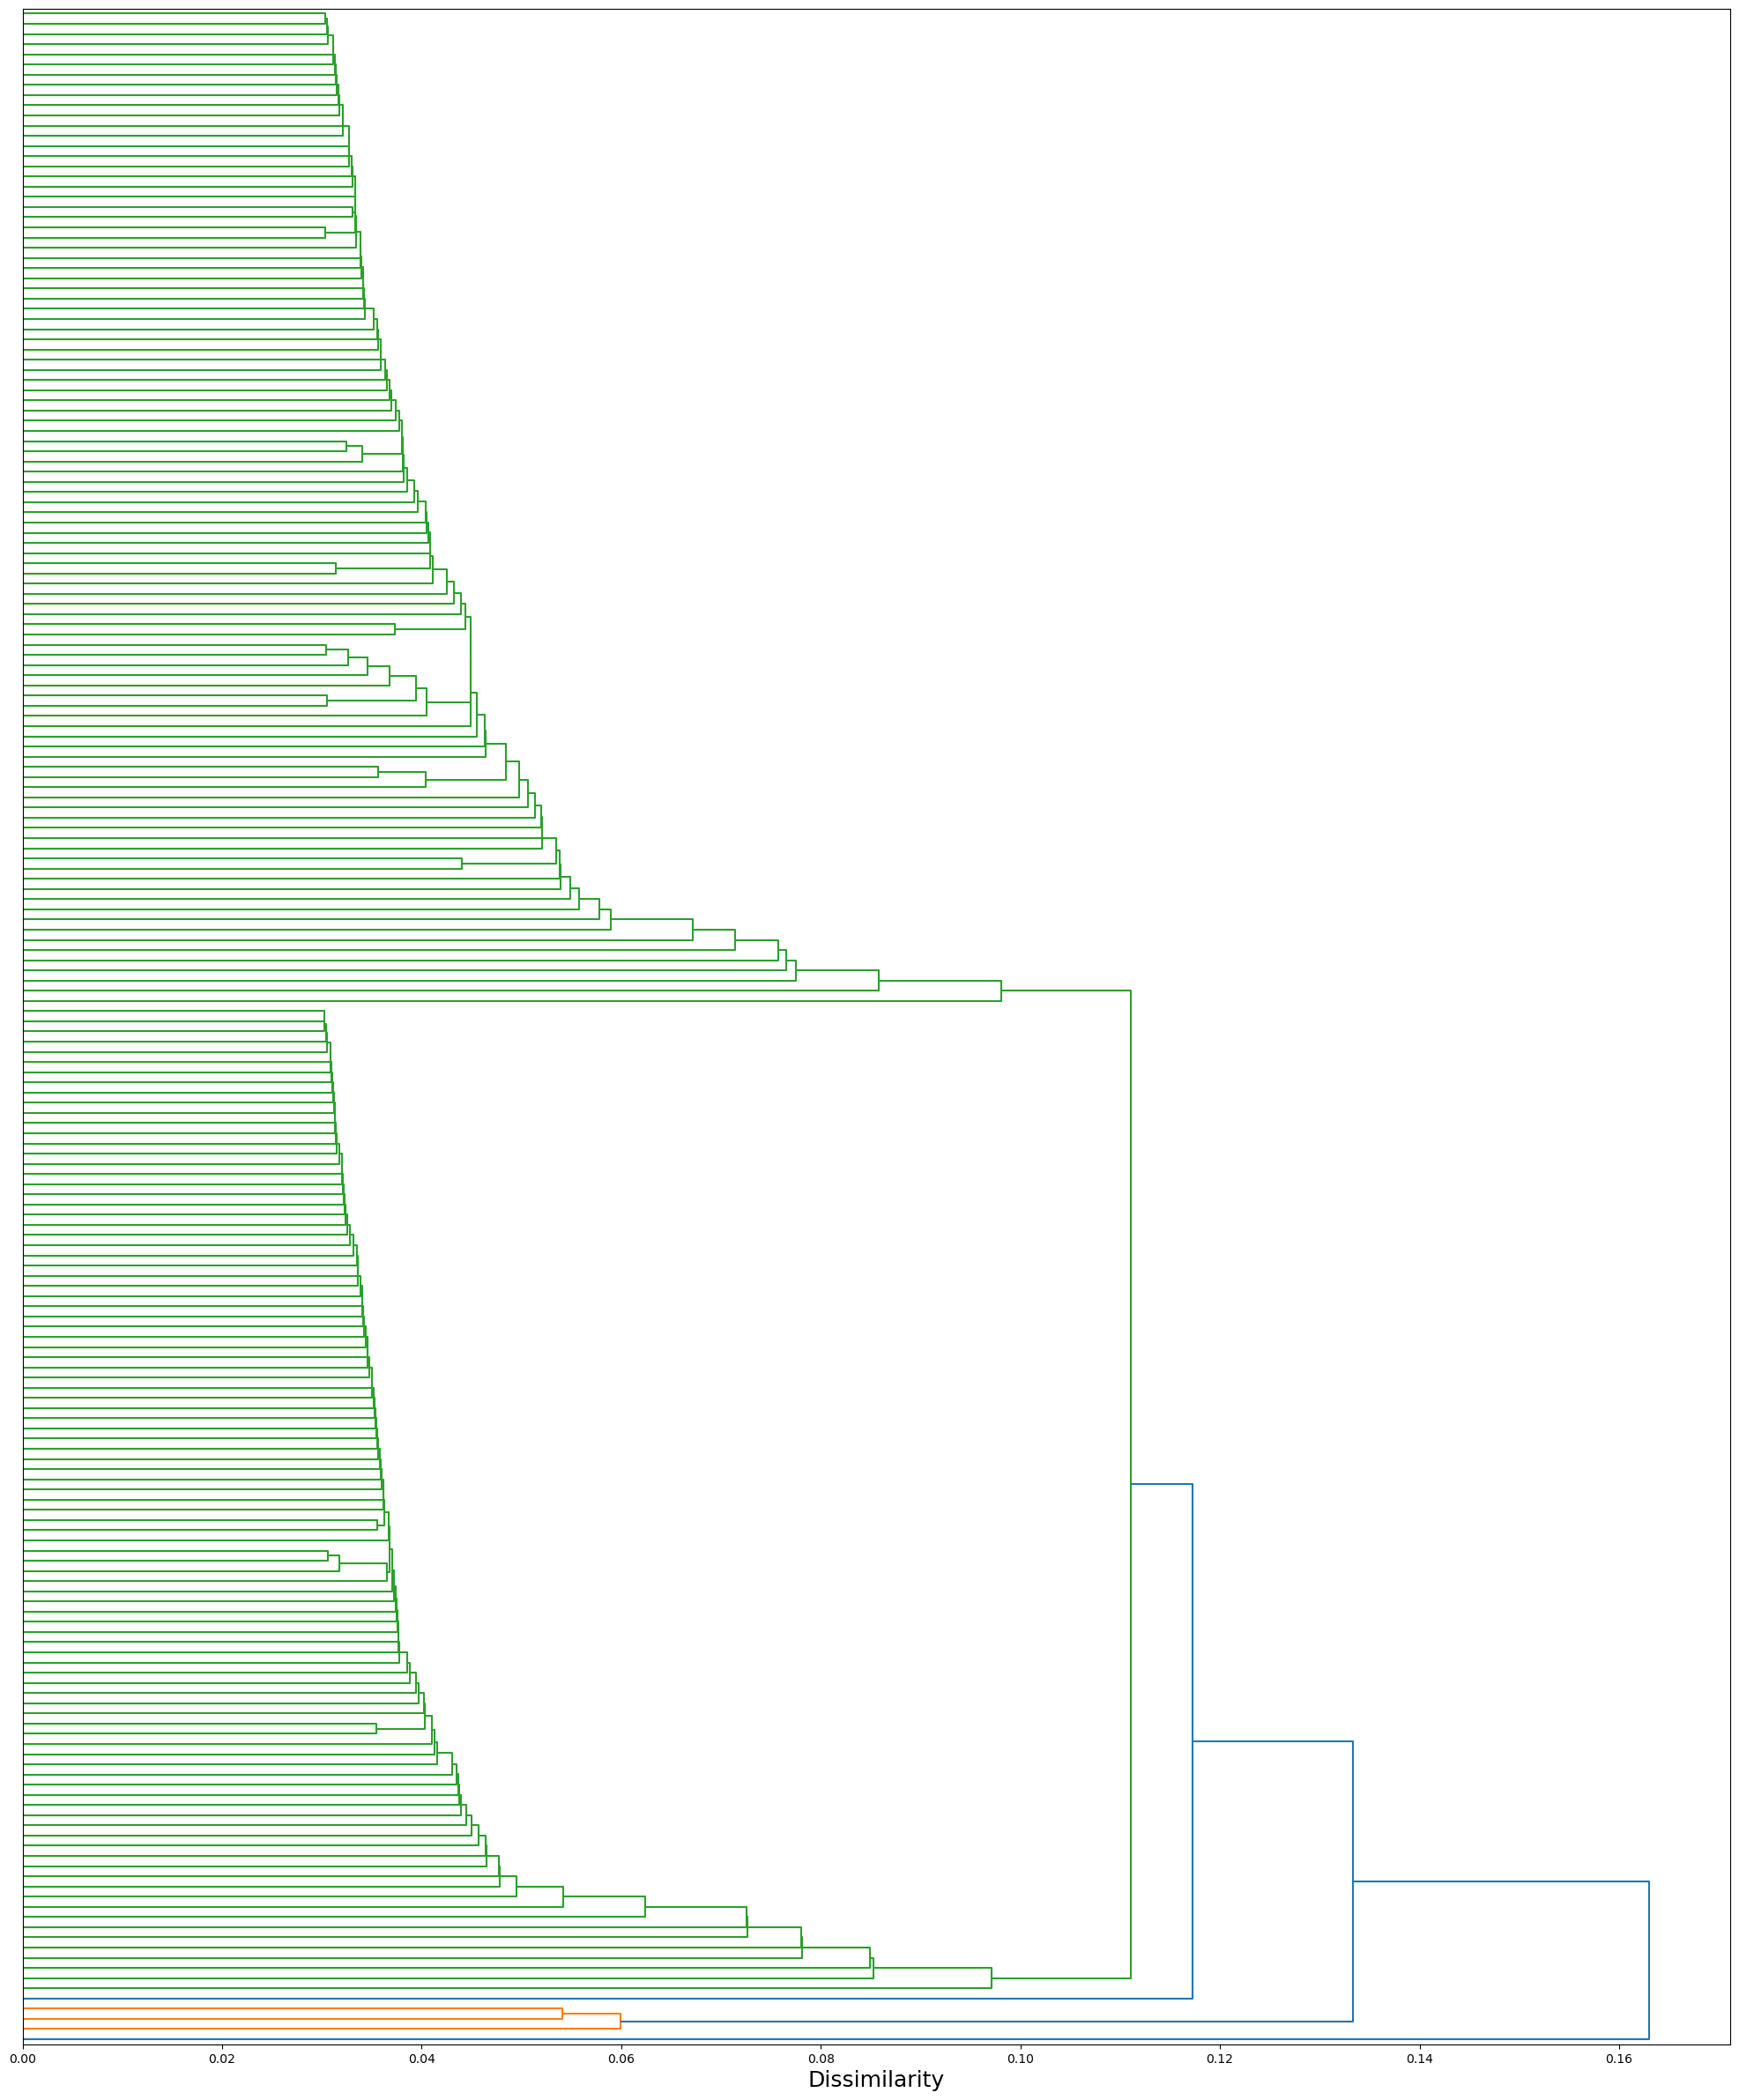

In [16]:
dist_mat = gower_matrix(df_data)
dist_mat = squareform(dist_mat, force = 'tovector')

Z = linkage(dist_mat, method='single')

fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax, truncate_mode='lastp', p=200, no_labels=True)
ax.set_xlabel('Dissimilarity', fontsize=18)
plt.show()

By conducting the HAC with single linkage and its dendrogram, we find that there are outliers in the high-dimensional space. since the dendrogram shows that there are several singletons that are the last to be merged into the main cluster.

### 3.4 Outlier Consideration

We propose clustering the identified outliers with larger clusters that may be located further away. This decision is justified by our research motivation and the nature of our dataset, which suggest that some patients diagnosed with diabetes may have elevated indicators that contribute to the condition. Given our need to investigate the clustering patterns of diabetes, it is imperative to retain patients with these elevated indicators within a single cluster to ensure the meaningfulness of our clustering results.

### 3.5 Noise Consideration and Identification

We will use DBSCAN and make k nearest neighbor sorted distance plot to identify the noise.

Before we run DBSCAN on the dataset, we need to label encode the "Gender" column since the DBSCAN does not support the categorical column.

In [17]:
df_data_encoded = df_data.copy()

label_enc = {}
label_enc["Gender"] = LabelEncoder()
df_data_encoded["Gender"] = label_enc["Gender"].fit_transform(df_data_encoded["Gender"])

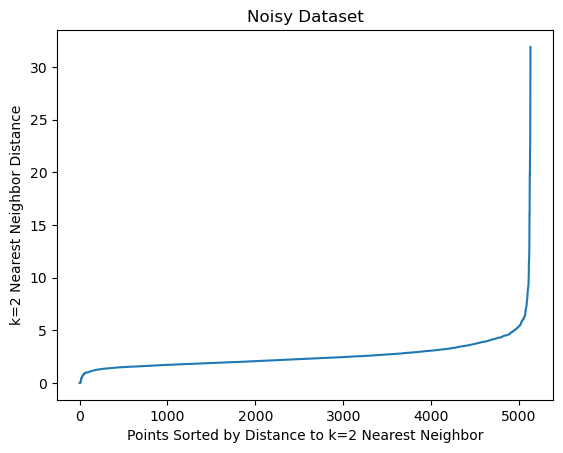

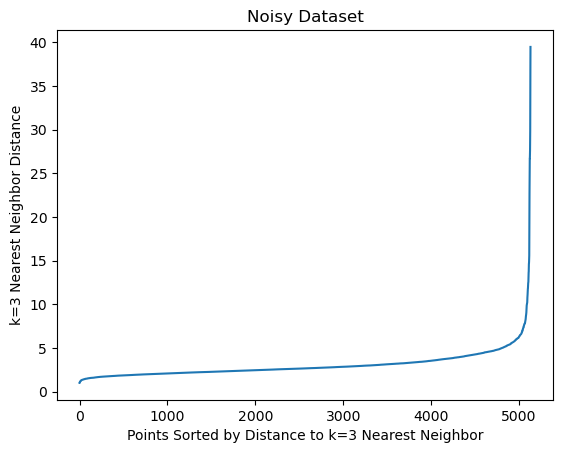

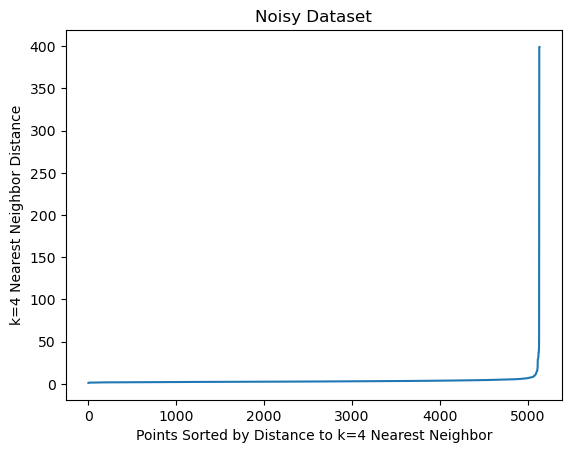

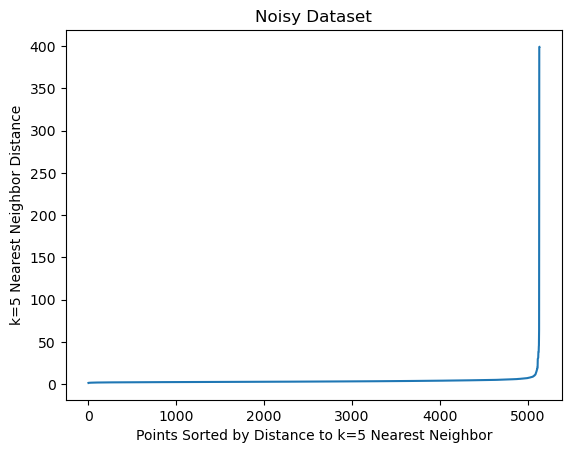

In [18]:
for k in range(2,6):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(df_data_encoded)
    distances, indices = nbrs.kneighbors(df_data_encoded)

    plt.plot(np.sort(distances.T[k-1]))
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

Based on the k-nearest neighbor sorted distance plot, we can see that there are significantly larger k-nearest neighbor distance start at some points, and that there may be noise in this dataset. However, like outliers, depending on the goals of our study and the nature of the dataset, these noises are not problematic, and they will be clustered into larger clusters that may happen to be farther apart, and therefore will not affect the types of clustering algorithms or clustering assessment metrics that we may use in your analysis. Since these noises, like outliers may be patients diagnosed with diabetes and have abnormal indicators, they are considered to be in one or more clusters. In addition, we can see that the curve starts to rise sharply at more than 5,000 points, whereas we only have 5132 observations in our dataset, so only a few points are considered noise, so this is not a problem for our further clustering analysis.

### 3.6 Other Data Cleaning

Here is our current dataset:

In [19]:
df_data

Age Gender  BMI  Chol    TG   HDL   LDL    Cr   BUN
0      50      F   24  4.20  0.90  2.40  1.40  46.0  4.70
1      26      M   23  3.70  1.40  1.10  2.10  62.0  4.50
2      33      M   21  4.90  1.00  0.80  2.00  46.0  7.10
3      45      F   21  2.90  1.00  1.00  1.50  24.0  2.30
4      50      F   24  3.60  1.30  0.90  2.10  50.0  2.00
...   ...    ...  ...   ...   ...   ...   ...   ...   ...
5127   54      M   23  5.00  1.50  1.24  2.98  77.0  3.50
5128   50      F   22  4.37  2.09  1.37  2.29  47.3  4.40
5129   67      M   24  3.89  1.38  1.14  2.17  70.6  4.73
5130   60      F   29  5.91  1.29  1.73  2.85  50.2  7.33
5131   37      M   34  5.42  2.66  1.08  2.87  75.5  4.61

[5132 rows x 9 columns]

Everything looks good. No further data cleaning is needed.

## 4. Basic Descriptive Analytics

In [20]:
df

Age Gender  BMI  Chol    TG   HDL   LDL    Cr   BUN  Diagnosis
0      50      F   24  4.20  0.90  2.40  1.40  46.0  4.70          0
1      26      M   23  3.70  1.40  1.10  2.10  62.0  4.50          0
2      33      M   21  4.90  1.00  0.80  2.00  46.0  7.10          0
3      45      F   21  2.90  1.00  1.00  1.50  24.0  2.30          0
4      50      F   24  3.60  1.30  0.90  2.10  50.0  2.00          0
...   ...    ...  ...   ...   ...   ...   ...   ...   ...        ...
5127   54      M   23  5.00  1.50  1.24  2.98  77.0  3.50          1
5128   50      F   22  4.37  2.09  1.37  2.29  47.3  4.40          1
5129   67      M   24  3.89  1.38  1.14  2.17  70.6  4.73          1
5130   60      F   29  5.91  1.29  1.73  2.85  50.2  7.33          1
5131   37      M   34  5.42  2.66  1.08  2.87  75.5  4.61          1

[5132 rows x 10 columns]

As displayed above, our dataset is a structured dataset consisting of mostly numerical data with only one categorical attribute(Gender). Thus, we will perform basic data analysis following option 1 proposed by the project specification.

### 4.1 Numerical Data

Below are the numerical data, they are:
    Age, BMI, Chol, TG, HDL, LDL, Cr, and BUN

In [21]:
df_num = df.select_dtypes(include=['float64', 'int64'])
df_num

Age  BMI  Chol    TG   HDL   LDL    Cr   BUN  Diagnosis
0      50   24  4.20  0.90  2.40  1.40  46.0  4.70          0
1      26   23  3.70  1.40  1.10  2.10  62.0  4.50          0
2      33   21  4.90  1.00  0.80  2.00  46.0  7.10          0
3      45   21  2.90  1.00  1.00  1.50  24.0  2.30          0
4      50   24  3.60  1.30  0.90  2.10  50.0  2.00          0
...   ...  ...   ...   ...   ...   ...   ...   ...        ...
5127   54   23  5.00  1.50  1.24  2.98  77.0  3.50          1
5128   50   22  4.37  2.09  1.37  2.29  47.3  4.40          1
5129   67   24  3.89  1.38  1.14  2.17  70.6  4.73          1
5130   60   29  5.91  1.29  1.73  2.85  50.2  7.33          1
5131   37   34  5.42  2.66  1.08  2.87  75.5  4.61          1

[5132 rows x 9 columns]

Then, let's take a further look at the summary statistic of the numerical data

In [22]:
df_num.describe()

Age          BMI         Chol           TG          HDL  \
count  5132.000000  5132.000000  5132.000000  5132.000000  5132.000000   
mean     48.950312    24.613406     4.866882     1.719328     1.593305   
std      14.048794     4.277205     1.001052     1.327057     1.038849   
min      20.000000    15.000000     0.000000     0.000000     0.000000   
25%      36.000000    22.000000     4.190000     0.910000     1.090000   
50%      49.000000    24.000000     4.800000     1.380000     1.300000   
75%      59.000000    27.000000     5.460000     2.100000     1.590000   
max      93.000000    47.000000    11.650000    32.640000     9.900000   

               LDL           Cr          BUN    Diagnosis  
count  5132.000000  5132.000000  5132.000000  5132.000000  
mean      2.914121    71.144800     4.896969     0.388348  
std       0.945423    28.494394     1.689206     0.487422  
min       0.300000     4.860753     0.500000     0.000000  
25%       2.290000    58.000000     3.900000     0.000000  
50%       2.790000    70.200000     4.720000     0.000000  
75%       3.400000    81.600000     5.600000     1.000000  
max       9.900000   800.000000    38.900000     1.000000

As we can see from the summary statistics, there is a large scale difference among all the attributes, indicating a need for scaling the dataset. 

Now, let's visualize the distrubtion of the numerical data

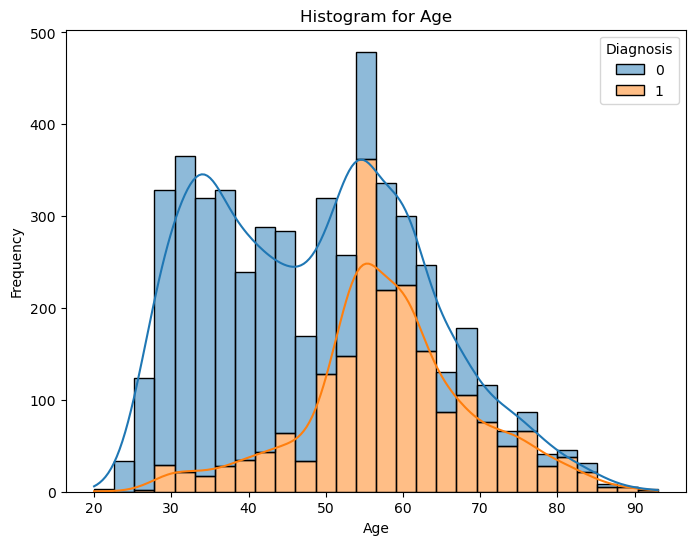

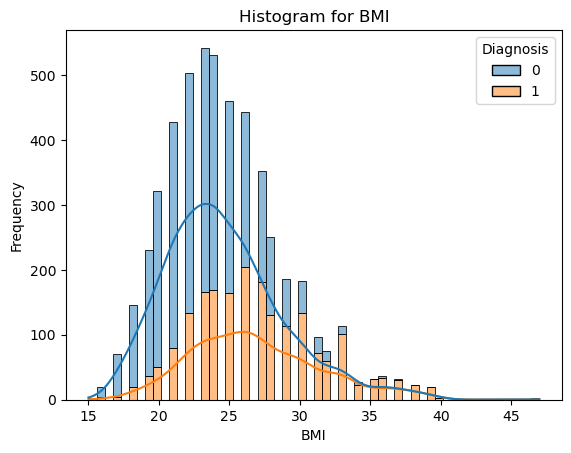

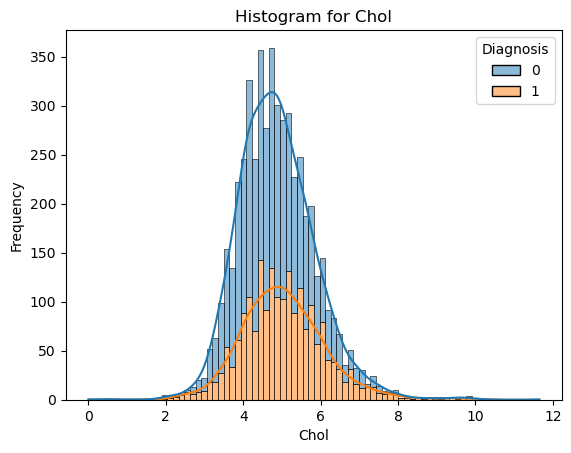

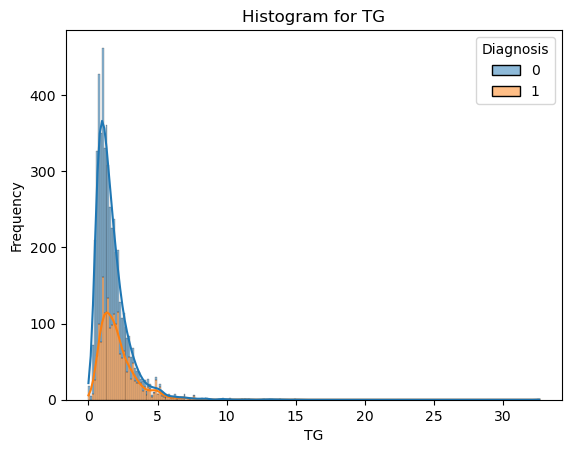

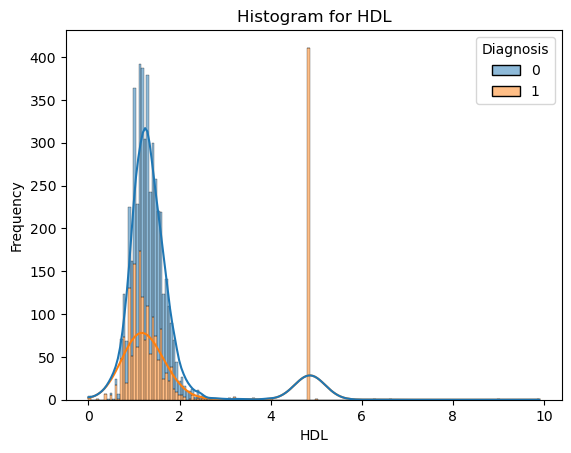

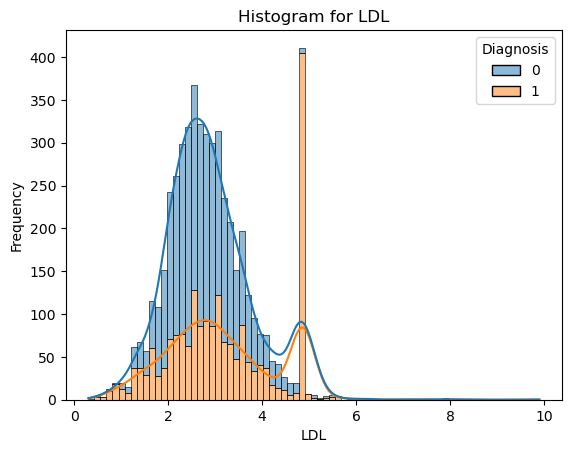

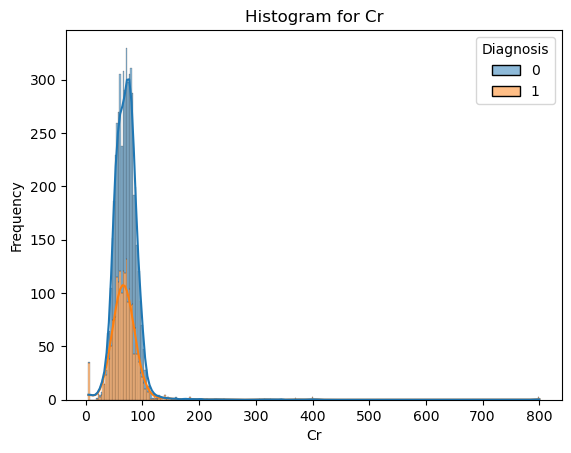

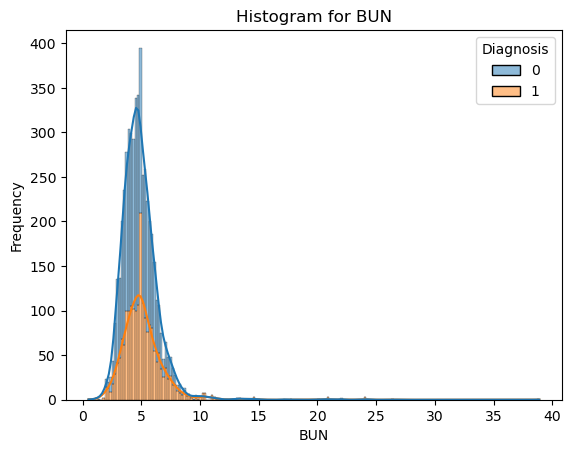

In [23]:
plt.figure(figsize=(8, 6))

for column in df_num.columns[:8]:
    sns.histplot(x=column, hue='Diagnosis', kde=True, multiple="stack", data=df_num)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Both the overall data and the diagnosed data shows a normal distribution or log-normal distribution, except LDL and HDL, with a sudden surge in the high range of the dataset, which shows a strong correlation with the diagnosis label. Data with high LDL or HDL are often diagnosed with diabetes

### 4.2 Categorical Data

First, Let's count up the pre-assigned label (Diagnosis) in this dataset

In [24]:
count_label = df['Diagnosis'].value_counts()
count_label

Diagnosis
0    3139
1    1993
Name: count, dtype: int64

Shown from the plot above, there are 3139 entries weren't diagnosed as diabetes, while 1993 entries were diagnosed as diabetes. 

Then will analyze the catecorial attributes in the dataset. We only have "Gender" as categorical data

In [25]:
df_cat = df["Gender"]
df_cat

0       F
1       M
2       M
3       F
4       F
       ..
5127    M
5128    F
5129    M
5130    F
5131    M
Name: Gender, Length: 5132, dtype: object

Then, let's take a further look into the gender distribution and also the rate of diagnosis

In [26]:
count = df_cat.value_counts()
count

Gender
M    3256
F    1876
Name: count, dtype: int64

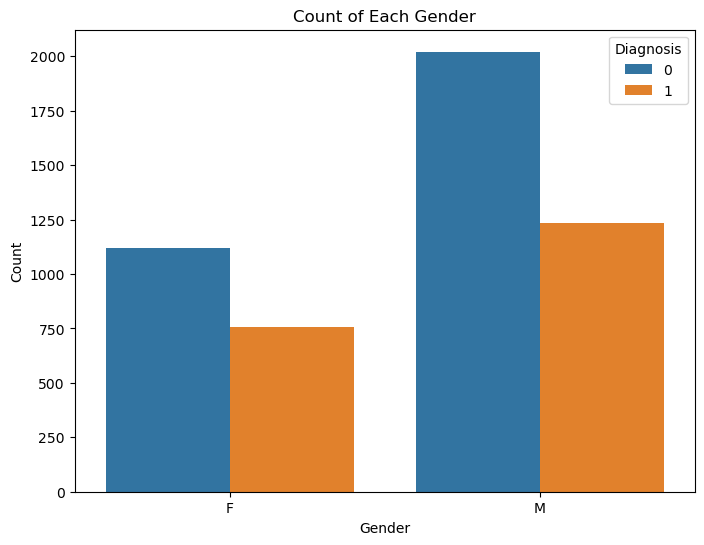

In [27]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='Gender', hue="Diagnosis")

plt.title('Count of Each Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the plot
plt.show()

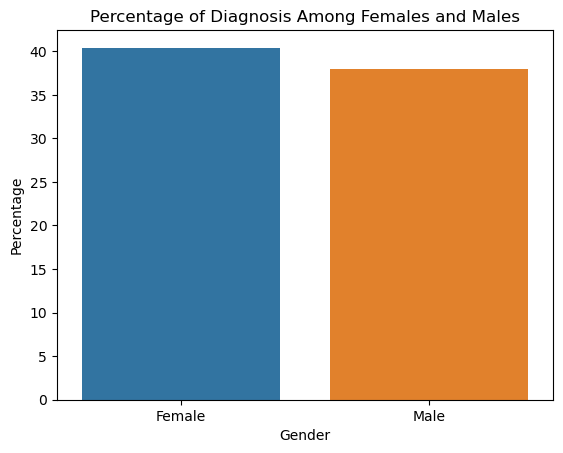

In [28]:
df_female = df[df['Gender'] == 'F']
female_diagnosis_percentage = (df_female[df_female['Diagnosis'] == 1].shape[0] / df_female.shape[0]) * 100

df_male = df[df['Gender'] == 'M']
male_diagnosis_percentage = (df_male[df_male['Diagnosis'] == 1].shape[0] / df_male.shape[0]) * 100

sns.barplot(x=['Female', 'Male'], y=[female_diagnosis_percentage, male_diagnosis_percentage])
plt.title('Percentage of Diagnosis Among Females and Males')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.show()

As denoted above, females tend to have a slightly higher rate of diagnosis of diabetes than male.

### 4.3 pairwise relationships

Now, let's explore the pairwise relationships among the dataset

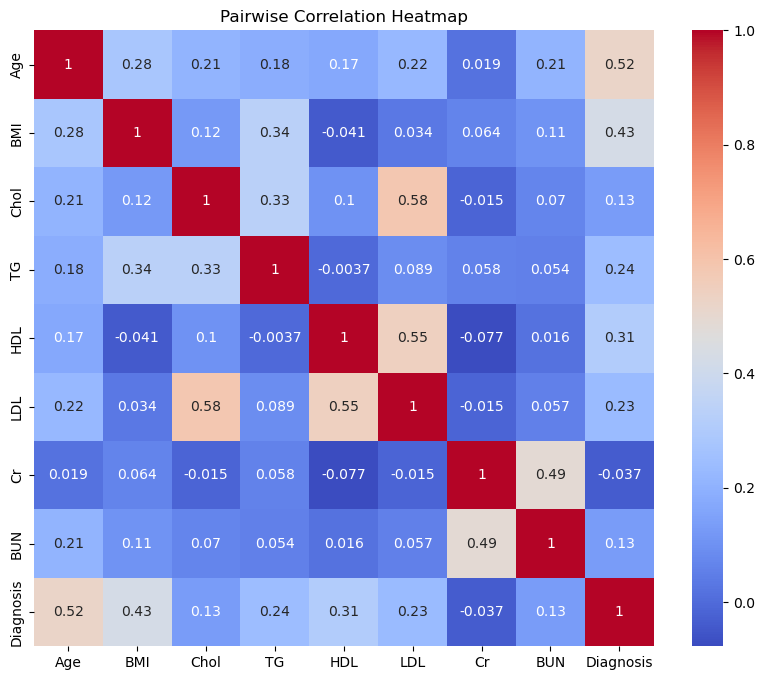

In [29]:
cor_mat = df_num.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm')
plt.title('Pairwise Correlation Heatmap')
plt.show()

Denoted from the plot, there are some very strong pairwise relationship among the dataset:
- Age with Diagnosis (label) : 0.52
- BMI with Diagnosis (label) : 0.43
- HDL with Diagnosis (label) : 0.31
- Chol with LDL : 0.58
- HDL with LDL : 0.55
- CR with BUN : 0.49

## 5. Scaling Decisions

### 5.1 Scale nessecity

In [30]:
df.describe()

Age          BMI         Chol           TG          HDL  \
count  5132.000000  5132.000000  5132.000000  5132.000000  5132.000000   
mean     48.950312    24.613406     4.866882     1.719328     1.593305   
std      14.048794     4.277205     1.001052     1.327057     1.038849   
min      20.000000    15.000000     0.000000     0.000000     0.000000   
25%      36.000000    22.000000     4.190000     0.910000     1.090000   
50%      49.000000    24.000000     4.800000     1.380000     1.300000   
75%      59.000000    27.000000     5.460000     2.100000     1.590000   
max      93.000000    47.000000    11.650000    32.640000     9.900000   

               LDL           Cr          BUN    Diagnosis  
count  5132.000000  5132.000000  5132.000000  5132.000000  
mean      2.914121    71.144800     4.896969     0.388348  
std       0.945423    28.494394     1.689206     0.487422  
min       0.300000     4.860753     0.500000     0.000000  
25%       2.290000    58.000000     3.900000     0.000000  
50%       2.790000    70.200000     4.720000     0.000000  
75%       3.400000    81.600000     5.600000     1.000000  
max       9.900000   800.000000    38.900000     1.000000

As shown from the describe above, among all the numercial attributes, they have very distrinct mean and standard deviation. Thus there is a large scale difference presented in the dataset and calls for the need of scalding.

### 5.2 Scale

To better accommadate the following cluster algorithm, we scaled the dataset in two ways: 
1. Scale only the numerical data (df_scaled)
2. Convert the "Gender" attribute from F/M to 0/1 and then scale (df_encoded_scaled)

In [31]:
df_num.drop(['Diagnosis'], axis=1, inplace=True)

In [32]:
df_num

Age  BMI  Chol    TG   HDL   LDL    Cr   BUN
0      50   24  4.20  0.90  2.40  1.40  46.0  4.70
1      26   23  3.70  1.40  1.10  2.10  62.0  4.50
2      33   21  4.90  1.00  0.80  2.00  46.0  7.10
3      45   21  2.90  1.00  1.00  1.50  24.0  2.30
4      50   24  3.60  1.30  0.90  2.10  50.0  2.00
...   ...  ...   ...   ...   ...   ...   ...   ...
5127   54   23  5.00  1.50  1.24  2.98  77.0  3.50
5128   50   22  4.37  2.09  1.37  2.29  47.3  4.40
5129   67   24  3.89  1.38  1.14  2.17  70.6  4.73
5130   60   29  5.91  1.29  1.73  2.85  50.2  7.33
5131   37   34  5.42  2.66  1.08  2.87  75.5  4.61

[5132 rows x 8 columns]

In [33]:
scaled_num = StandardScaler().fit_transform(df_num)
df_num_scaled = pd.DataFrame(scaled_num, columns=df_num.columns)
df_num_scaled

Age       BMI      Chol        TG       HDL       LDL        Cr  \
0     0.074725 -0.143427 -0.666247 -0.617462  0.776604 -1.601683 -0.882533   
1    -1.633774 -0.377247 -1.165770 -0.240652 -0.474903 -0.861202 -0.320965   
2    -1.135462 -0.844888  0.033086 -0.542100 -0.763712 -0.966985 -0.882533   
3    -0.281213 -0.844888 -1.965007 -0.542100 -0.571173 -1.495900 -1.654690   
4     0.074725 -0.143427 -1.265675 -0.316014 -0.667443 -0.861202 -0.742141   
...        ...       ...       ...       ...       ...       ...       ...   
5127  0.359474 -0.377247  0.132991 -0.165290 -0.340126  0.069689  0.205506   
5128  0.074725 -0.611067 -0.496409  0.279346 -0.214975 -0.660214 -0.836906   
5129  1.284911 -0.143427 -0.975951 -0.255724 -0.436395 -0.787154 -0.019121   
5130  0.786599  1.025675  1.042123 -0.323550  0.131596 -0.067829 -0.735121   
5131 -0.850712  2.194776  0.552590  0.708910 -0.494157 -0.046672  0.152859   

           BUN  
0    -0.116616  
1    -0.235026  
2     1.304309  
3    -1.537540  
4    -1.715156  
...        ...  
5127 -0.827078  
5128 -0.294231  
5129 -0.098854  
5130  1.440481  
5131 -0.169901  

[5132 rows x 8 columns]

In [34]:
df_scaled = pd.concat([df_num_scaled, df['Gender']], axis=1)
df_scaled_w_label = pd.concat([df_scaled, df_label], axis=1)
df_scaled_w_label

Age       BMI      Chol        TG       HDL       LDL        Cr  \
0     0.074725 -0.143427 -0.666247 -0.617462  0.776604 -1.601683 -0.882533   
1    -1.633774 -0.377247 -1.165770 -0.240652 -0.474903 -0.861202 -0.320965   
2    -1.135462 -0.844888  0.033086 -0.542100 -0.763712 -0.966985 -0.882533   
3    -0.281213 -0.844888 -1.965007 -0.542100 -0.571173 -1.495900 -1.654690   
4     0.074725 -0.143427 -1.265675 -0.316014 -0.667443 -0.861202 -0.742141   
...        ...       ...       ...       ...       ...       ...       ...   
5127  0.359474 -0.377247  0.132991 -0.165290 -0.340126  0.069689  0.205506   
5128  0.074725 -0.611067 -0.496409  0.279346 -0.214975 -0.660214 -0.836906   
5129  1.284911 -0.143427 -0.975951 -0.255724 -0.436395 -0.787154 -0.019121   
5130  0.786599  1.025675  1.042123 -0.323550  0.131596 -0.067829 -0.735121   
5131 -0.850712  2.194776  0.552590  0.708910 -0.494157 -0.046672  0.152859   

           BUN Gender  Diagnosis  
0    -0.116616      F          0  
1    -0.235026      M          0  
2     1.304309      M          0  
3    -1.537540      F          0  
4    -1.715156      F          0  
...        ...    ...        ...  
5127 -0.827078      M          1  
5128 -0.294231      F          1  
5129 -0.098854      M          1  
5130  1.440481      F          1  
5131 -0.169901      M          1  

[5132 rows x 10 columns]

In [35]:
scaled_all = StandardScaler().fit_transform(df_data_encoded)
df_encoded_scaled = pd.DataFrame(scaled_all, columns=df_data_encoded.columns)
df_encoded_scaled_w_label = pd.concat([df_encoded_scaled, df_label], axis=1)
df_encoded_scaled_w_label

Age    Gender       BMI      Chol        TG       HDL       LDL  \
0     0.074725 -1.317425 -0.143427 -0.666247 -0.617462  0.776604 -1.601683   
1    -1.633774  0.759057 -0.377247 -1.165770 -0.240652 -0.474903 -0.861202   
2    -1.135462  0.759057 -0.844888  0.033086 -0.542100 -0.763712 -0.966985   
3    -0.281213 -1.317425 -0.844888 -1.965007 -0.542100 -0.571173 -1.495900   
4     0.074725 -1.317425 -0.143427 -1.265675 -0.316014 -0.667443 -0.861202   
...        ...       ...       ...       ...       ...       ...       ...   
5127  0.359474  0.759057 -0.377247  0.132991 -0.165290 -0.340126  0.069689   
5128  0.074725 -1.317425 -0.611067 -0.496409  0.279346 -0.214975 -0.660214   
5129  1.284911  0.759057 -0.143427 -0.975951 -0.255724 -0.436395 -0.787154   
5130  0.786599 -1.317425  1.025675  1.042123 -0.323550  0.131596 -0.067829   
5131 -0.850712  0.759057  2.194776  0.552590  0.708910 -0.494157 -0.046672   

            Cr       BUN  Diagnosis  
0    -0.882533 -0.116616          0  
1    -0.320965 -0.235026          0  
2    -0.882533  1.304309          0  
3    -1.654690 -1.537540          0  
4    -0.742141 -1.715156          0  
...        ...       ...        ...  
5127  0.205506 -0.827078          1  
5128 -0.836906 -0.294231          1  
5129 -0.019121 -0.098854          1  
5130 -0.735121  1.440481          1  
5131  0.152859 -0.169901          1  

[5132 rows x 10 columns]

- df_scaled: numerical variable scaled without label.
- df_scaled_w_label: numerical variable scaled with label.
- df_encoded_scaled: encoded 'Gender' + scaled without label.
- df_encoded_scaled_w_label: encoded 'Gender' + scaled with label.

## 6. Clusterability and Clustering Structure

In [36]:
dist_mat = gower_matrix(df_scaled)
dist_mat

array([[0.        , 0.18309051, 0.18626583, ..., 0.1681547 , 0.08271734,
        0.2194586 ],
       [0.18309051, 0.        , 0.04468888, ..., 0.07088366, 0.23073584,
        0.08697207],
       [0.18626583, 0.04468888, 0.        , ..., 0.08917215, 0.21213287,
        0.08637661],
       ...,
       [0.1681547 , 0.07088366, 0.08917215, ..., 0.        , 0.18356465,
        0.10914109],
       [0.08271734, 0.23073584, 0.21213287, ..., 0.18356465, 0.        ,
        0.19174924],
       [0.2194586 , 0.08697207, 0.08637661, ..., 0.10914109, 0.19174924,
        0.        ]], dtype=float32)

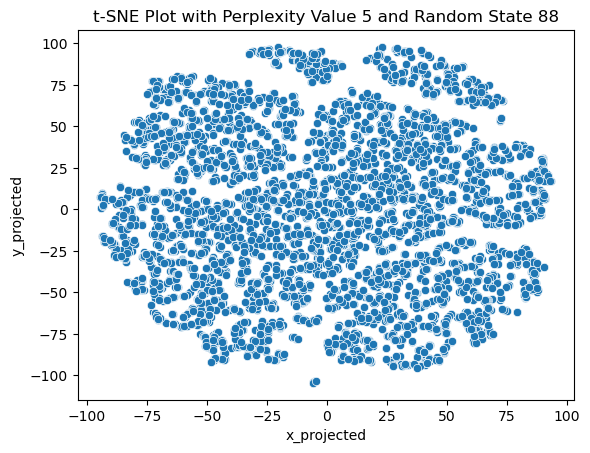

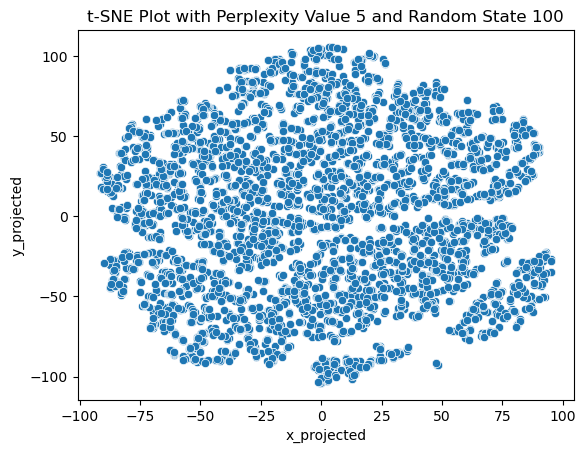

--------------------------------------------


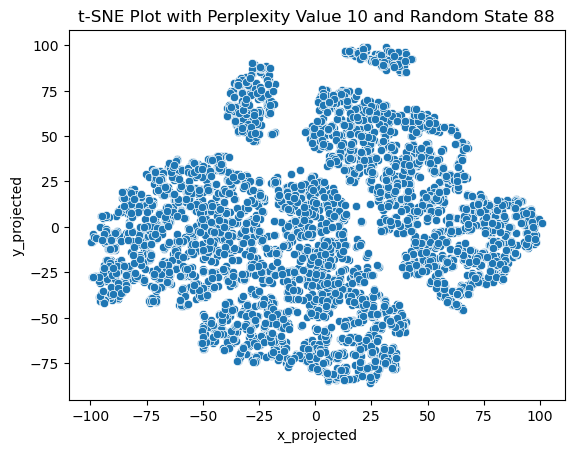

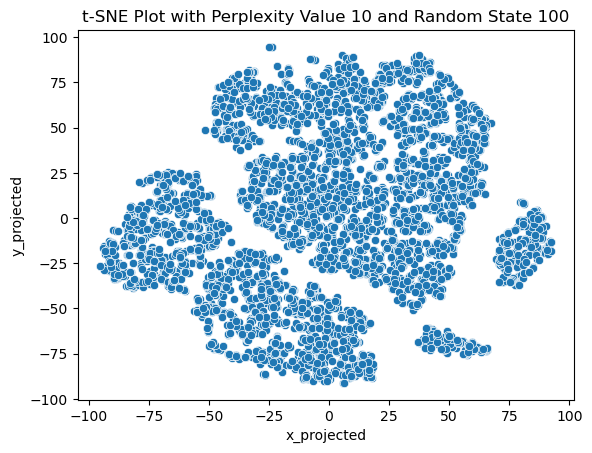

--------------------------------------------


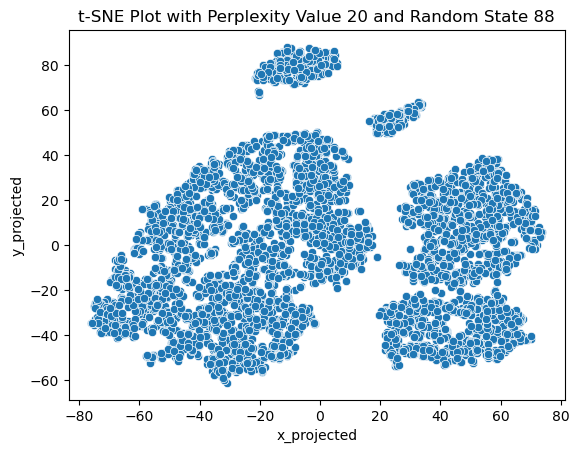

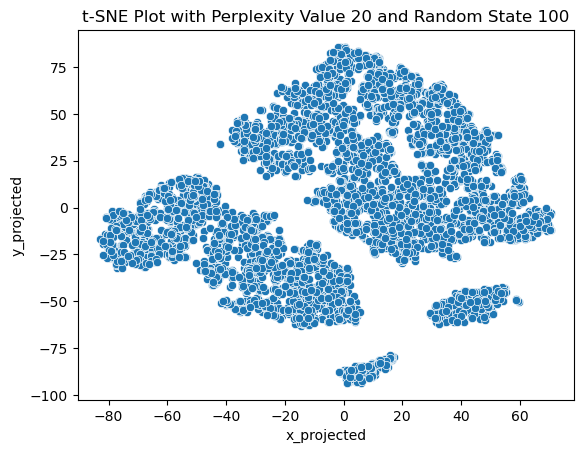

--------------------------------------------


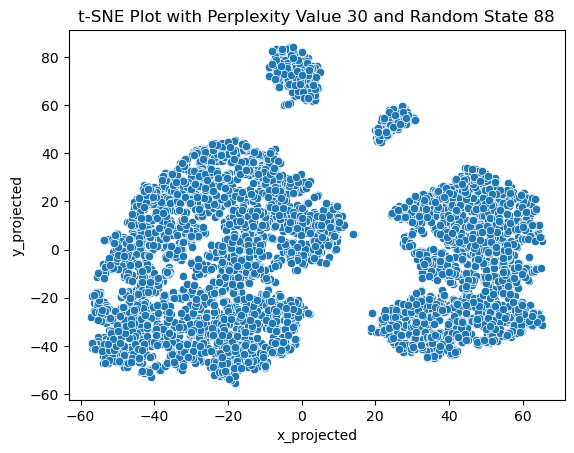

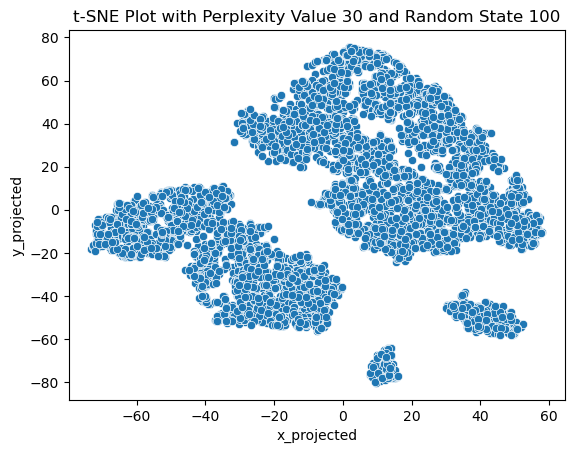

--------------------------------------------


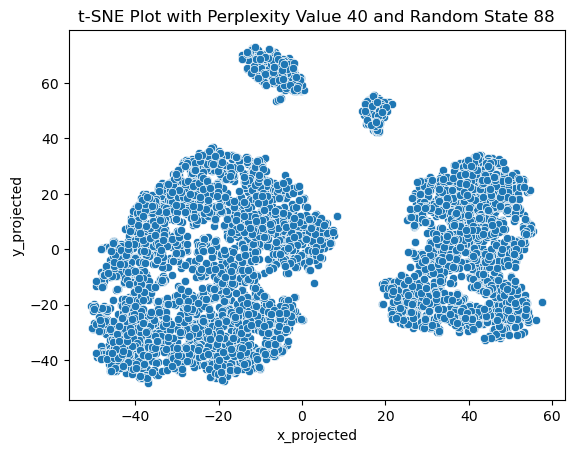

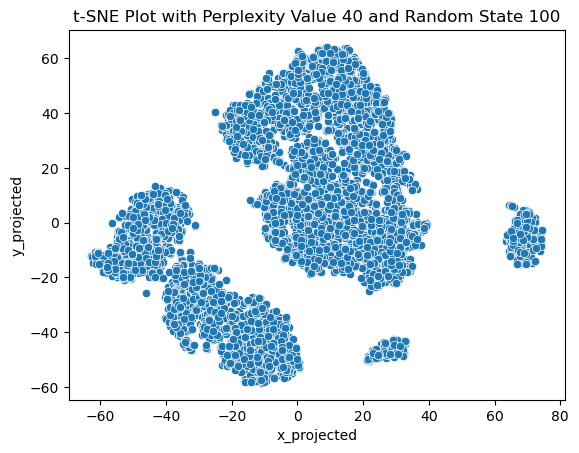

--------------------------------------------


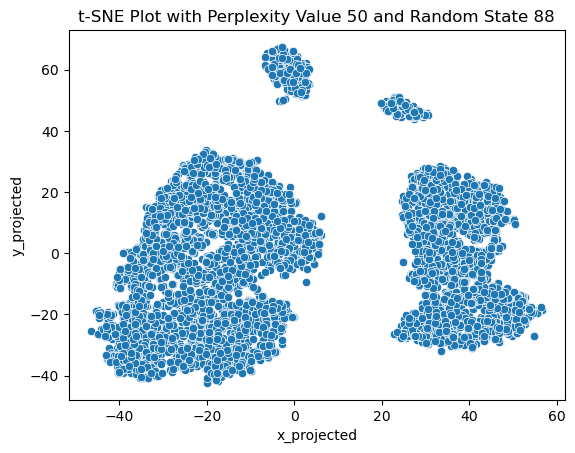

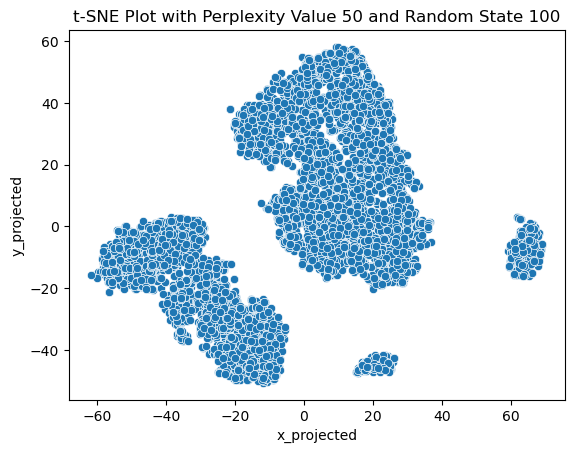

--------------------------------------------


In [37]:
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [88, 100]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed', init='random')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df_scaled_w_label, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

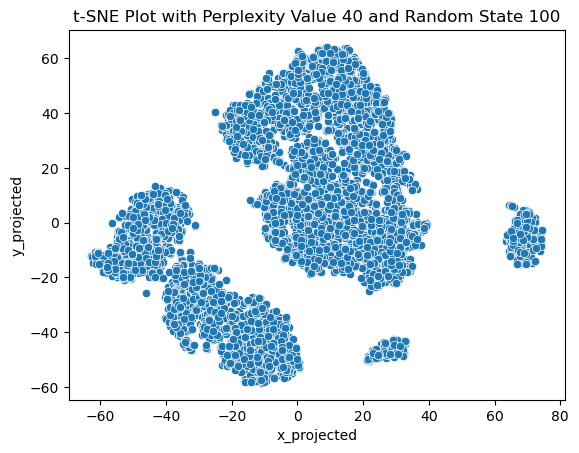

In [38]:
perp = 40
rs = 100

tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed', init='random')
data_tsne = tsne.fit_transform(dist_mat)
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df_scaled_w_label, df_tsne], axis=1)
sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
plt.show()

### 6.1 Clusterability
As shown in the t-SNE plot above, this dataset displays a very obviosus clustering struct: 
- There are four well-separated clusterings, with the cluster the left bottom consist of two nested sub-clusters.
- These clusterings are not well spherical, and are not balanced in size.

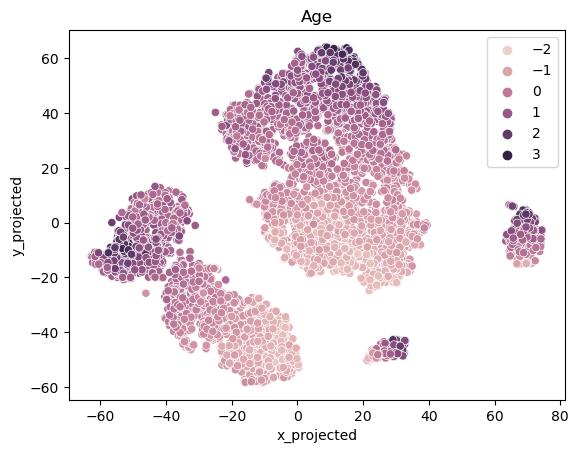

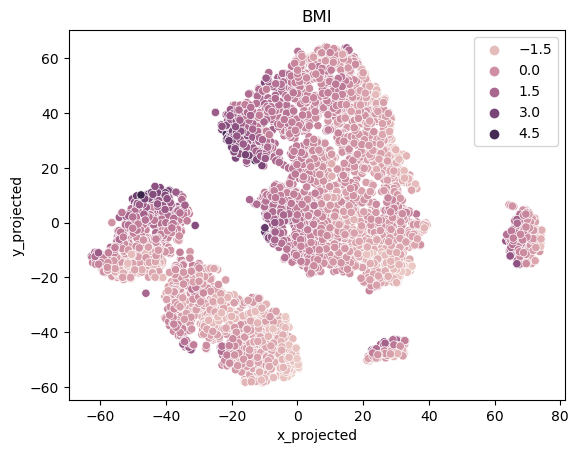

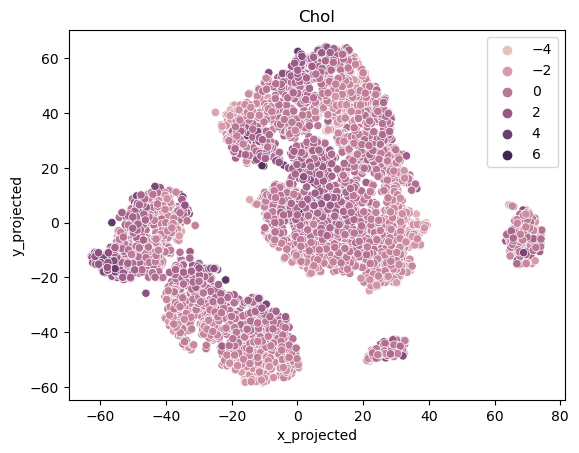

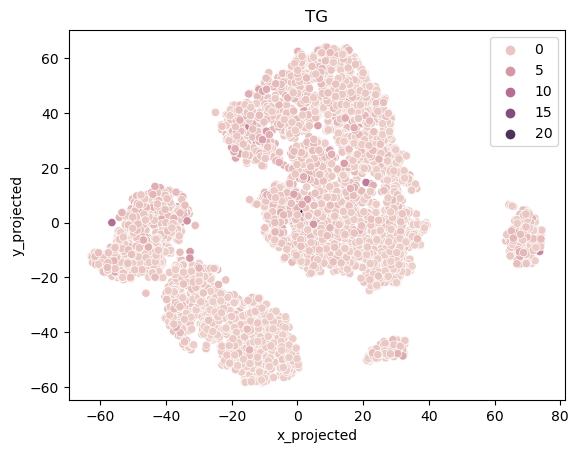

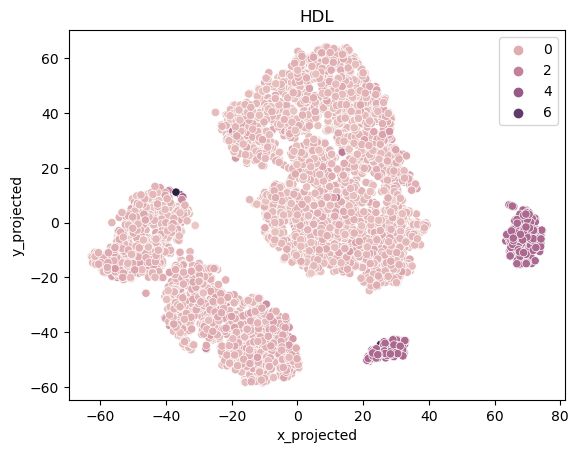

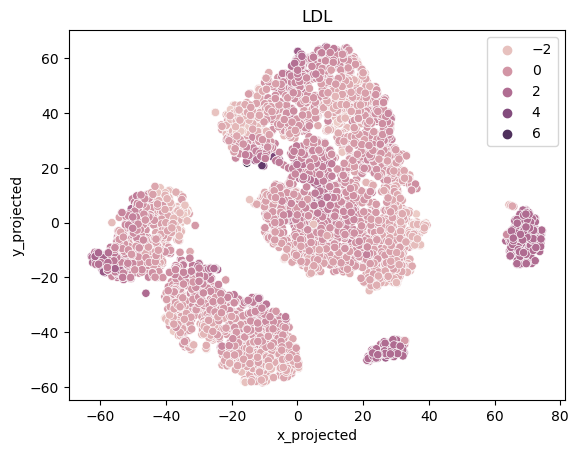

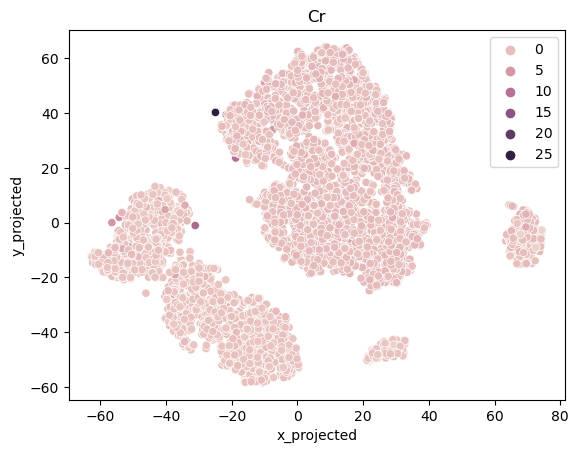

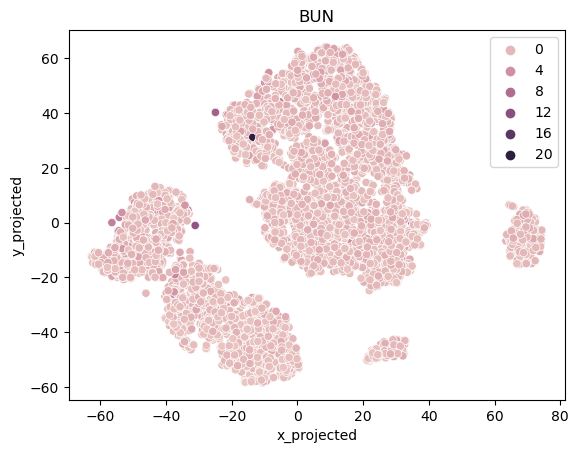

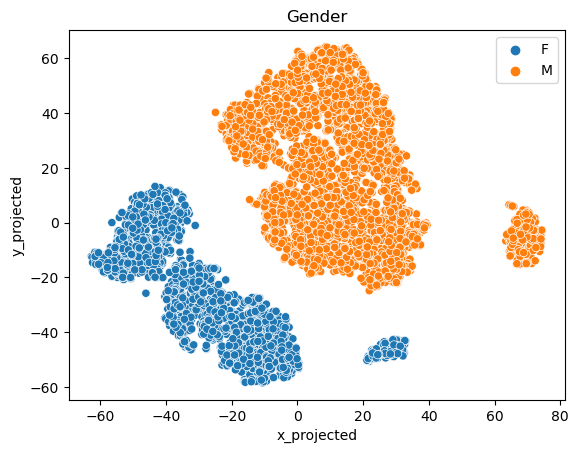

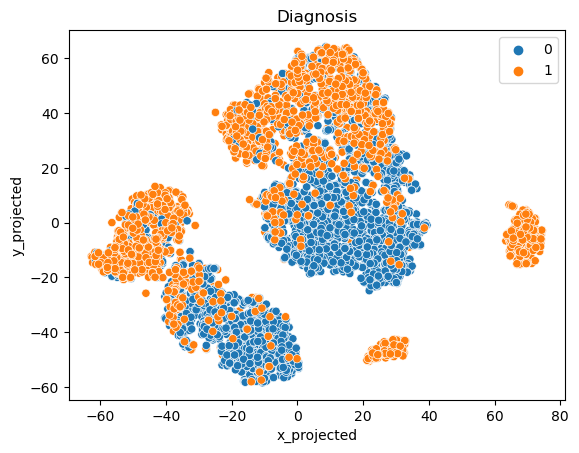

In [76]:
for col in df_combo.columns[:10]:
    sns.scatterplot(x='x_projected', y='y_projected', hue=col, data=df_combo)
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 6Attribu

## 7. Clustering Algorithm Selection Motivation

Research motivation:
According to the t-sne plot, it shows several compact cluster, and k-means can effectively assign each point to the closest centroid, which will be a useful way. Moreover, The dataset contains health-related metrics, including BMI, cholesterol, and other data. These attributes can create natural groupings, such as individuals with similar health profiles. K-means can partition these profiles into distinct clusters, and aim to help people analyze their healthy condition.


Ideal Dataset Properties:
The ideal cluster for k-mean are the clusters with balance size, same sparsity, and their cluster are almost spherical. Each cluster are well-separate and have similar observations in each cluster.

Research motivation:
GMM provides a way to get the probability of cluster, and model them as the Gaussian distribution. The flexibility allows the algorithm to capture different shapes and distributions.

Ideal Dataset Properties:
GMM algorithm works well for continues numerical feature, and when the cluster have different size, shape and sparsity, GMM has better performance.

I think there are some benefits to returning a fuzzy clustering. According to the t-sne plot, we can observe that there are some clusters contains some overlap points. In this situation, it will be better for us to use the fuzzy clustering, particularly in health-related data where conditions can have shared symptoms or characteristics.

I believe there is a benefit to return HAC. Because we are discussing various indicators of the body and the impact each indicator may have on people, and some physical diseases are caused by excessive health data. So we can use HAC to obtain their causal relationship and better analyze the cause. 


## 8. K-Means

### 8.1 Parameter Selection

In this section, we need to choose the parameters: number of clusters $k$ and the weight for categorical variable Gamma. For the choice of K, we provide a range of K s [1, 8], this is because in the t-SNE plot above we can see that there are four main clusters, and there may be some potential sub-clusters within these larger clusters.

#### 8.1.1 Elbow Plot

The first method we are going to use is the elbow plot method, as this is the most classical and reliable way to find the optimal number of clusters for k-means algorithm.

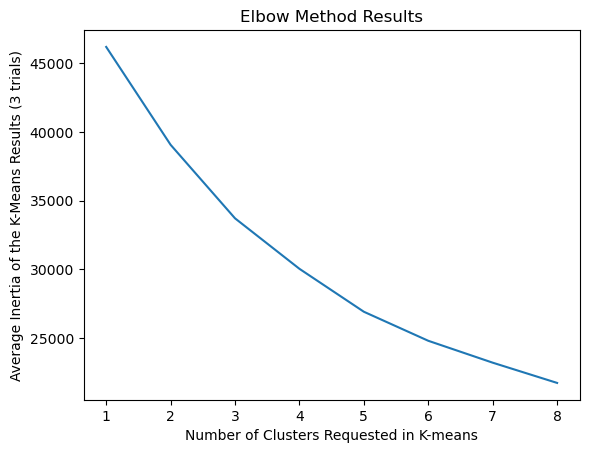

In [68]:
Ks = [1, 2, 3, 4, 5, 6, 7, 8]

avg_inertia_list = []
for k in Ks:
    sub_inertia_list = []
    for i in range(0, 3):
        kmeans = KMeans(n_clusters=k).fit(df_encoded_scaled)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

plt.plot(range(1, 9), avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.xticks(range(1, 9))
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results')
plt.show()

As we can see from the elbow plot above, there is no "dramatic" elbow in the plot, but we can still see some leveling off at k = 3 and k = 5.

#### 8.1.2 Average Silhouette Score Plots

In [41]:
Ks = [2, 3, 4, 5, 6, 7, 8]

avg_avg_sil_score_list = []
for k in Ks:
    avg_sil_score_list = []
    for i in range(0, 3):
        kmeans = KMeans(n_clusters = k).fit(df_encoded_scaled)
        cluster_labels = kmeans.labels_
        avg_sil_score = silhouette_score(df_encoded_scaled, cluster_labels)
        avg_sil_score_list.append(avg_sil_score)
    avg_avg_sil_score_list.append(np.average(avg_sil_score_list))

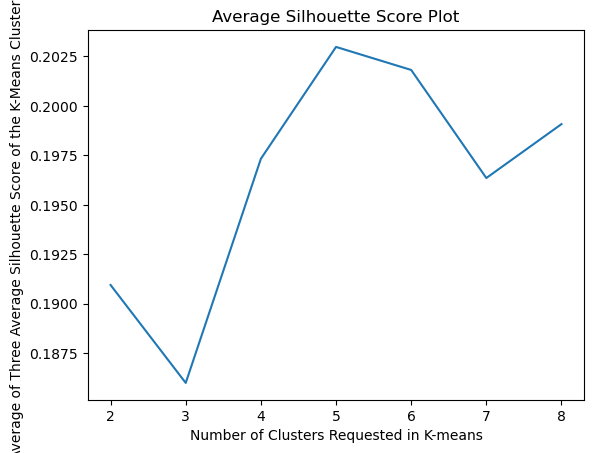

In [42]:
plt.plot(Ks, avg_avg_sil_score_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average of Three Average Silhouette Score of the K-Means Clusterings')
plt.title('Average Silhouette Score Plot')
plt.show()

As can be seen from the average silhouette score plot above, the average silhouette score is highest when k = 5 (and 6), which matches our findings in 8.1.1. And the reason 

Therefore, we choose k = 5 as the number of clusters.

### 8.2 Clustering the Data

In [43]:
k = 5
kmeans = KMeans(n_clusters = k, random_state = 100).fit(df_encoded_scaled)
kmeans.labels_

array([1, 2, 2, ..., 2, 0, 0], dtype=int32)

### 8.3 Clustering Algorithm Results Presentation

In [44]:
df_encoded_scaled_w_label['predicted_label'] = kmeans.labels_

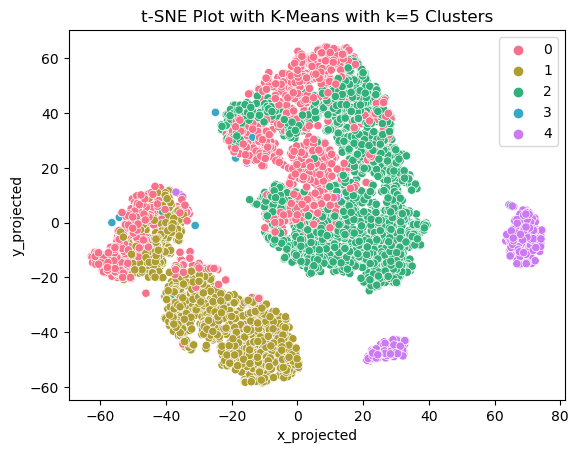

In [45]:
sns.scatterplot(x='x_projected',y='y_projected', hue=df_encoded_scaled_w_label['predicted_label'], palette=sns.color_palette("husl", k), data=df_combo)
plt.title('t-SNE Plot with K-Means with k=%s Clusters' %(k))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

From the t-SNE plots colored by cluster labels, we find some insight into the clustering, where most of the pink-labeled observations and all of the purple-labeled observations were diagnosed with diabetes (located in clusters 0 and 4). This proves that most of the observations in cluster 0 and cluster 4 are diagnosed as having diabetes, and we will go on to observe which body indicators are the main cause of diabetes in the subsequent investigation. Some of the observations diagnosed with diabetes have green and brown labels (in clusters 1 and 2), which may indicate that some diabetics may have the same body indicators as non-diabetics, which is also worth discussing later. In addition, we found some blue outliers, and from the t-SNE plots colored with "Diagnosis", it is clear that these observations are diagnosed with diabetes. This is also consistent with our findings in Sections 3.2 and 3.3 that some of the observations are outliers with abnormal body metrics, and that these individuals may have diabetes due to their abnormal indicators levels.

### 8.4 Additional Cluster Exploration

Although we can see in the color-coded t-SNE plot in the previous section that our clusters are not well-separated, we can still perform some cluster evaluation metrics to learn more about the clustering.

#### 8.4.1 Cluster-sorted Similarity Matrix

First, we wish to observe the distance between each pair of clusters and their sparsity by plotting the cluster-sorted similarity matrix.

In [46]:
df_sort = df_encoded_scaled_w_label.sort_values(by=['predicted_label'])
df_sort

Age    Gender       BMI      Chol        TG       HDL       LDL  \
5131 -0.850712  0.759057  2.194776  0.552590  0.708910 -0.494157 -0.046672   
3712  0.928974 -1.317425  0.324214  1.921284  0.837025  0.362644  1.413134   
1138 -0.708337  0.759057 -0.377247  1.231942  0.317027 -0.696324  1.497761   
3714  0.857786  0.759057  0.324214  0.442695  0.347172 -0.369006  0.556291   
1136  0.145912  0.759057 -0.143427  0.982180 -0.300942  0.449286  0.609183   
...        ...       ...       ...       ...       ...       ...       ...   
4753 -0.921899  0.759057  0.558034 -0.965961  0.512968  3.145565  2.059207   
4752 -0.210025  0.759057  0.090394 -0.166723  1.266589  3.145565  2.059207   
4751 -0.138838 -1.317425  1.727136  0.132991 -0.542100  3.145565  2.059207   
4084 -0.494775  0.759057  0.090394  0.902257 -0.180362  3.145565  2.059207   
4064  1.925598 -1.317425  1.727136 -0.476428  0.045724  3.145565  2.059207   

            Cr       BUN  Diagnosis  predicted_label  
5131  0.152859 -0.169901          1                0  
3712 -0.306925  0.416231          0                0  
1138  0.180937 -0.246867          0                0  
3714 -0.092827  0.878031          0                0  
1136  0.328349 -0.880363          0                0  
...        ...       ...        ...              ...  
4753  0.100212 -0.785635          1                4  
4752  0.837271  1.031965          1                4  
4751  0.065114 -1.123104          1                4  
4084 -0.040180  0.830667          1                4  
4064 -2.326440  1.452322          1                4  

[5132 rows x 11 columns]

In [47]:
df_sort.drop(['Diagnosis', 'predicted_label'], axis=1, inplace=True)
df_sort

Age    Gender       BMI      Chol        TG       HDL       LDL  \
5131 -0.850712  0.759057  2.194776  0.552590  0.708910 -0.494157 -0.046672   
3712  0.928974 -1.317425  0.324214  1.921284  0.837025  0.362644  1.413134   
1138 -0.708337  0.759057 -0.377247  1.231942  0.317027 -0.696324  1.497761   
3714  0.857786  0.759057  0.324214  0.442695  0.347172 -0.369006  0.556291   
1136  0.145912  0.759057 -0.143427  0.982180 -0.300942  0.449286  0.609183   
...        ...       ...       ...       ...       ...       ...       ...   
4753 -0.921899  0.759057  0.558034 -0.965961  0.512968  3.145565  2.059207   
4752 -0.210025  0.759057  0.090394 -0.166723  1.266589  3.145565  2.059207   
4751 -0.138838 -1.317425  1.727136  0.132991 -0.542100  3.145565  2.059207   
4084 -0.494775  0.759057  0.090394  0.902257 -0.180362  3.145565  2.059207   
4064  1.925598 -1.317425  1.727136 -0.476428  0.045724  3.145565  2.059207   

            Cr       BUN  
5131  0.152859 -0.169901  
3712 -0.306925  0.416231  
1138  0.180937 -0.246867  
3714 -0.092827  0.878031  
1136  0.328349 -0.880363  
...        ...       ...  
4753  0.100212 -0.785635  
4752  0.837271  1.031965  
4751  0.065114 -1.123104  
4084 -0.040180  0.830667  
4064 -2.326440  1.452322  

[5132 rows x 9 columns]

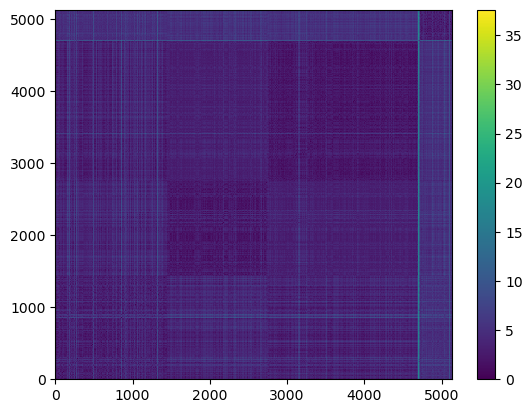

In [48]:
dist_mat = squareform(pdist(df_sort))

#Then visualize the distance matrix with a heat map.
plt.pcolormesh(dist_mat)
plt.colorbar()
N = len(df_sort)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

From the cluster-sorted distance matrix, we can see each pair of clusters are very close to each other which indicates the clusters are not well-separated. Also, some observations, like the observation at [4800, 4800], might be an outlier in this dataset.

#### 8.4.2 Silhouette Plot

A silhouette plot gives us more information about the cohesion and separation of each individual in each cluster.

In [49]:
def show_silhouette_plots(X,cluster_labels):

    # This package allows us to use "color maps" in our visualizations
    import matplotlib.cm as cm
    
    #How many clusters in your clustering?
    n_clusters=len(np.unique(cluster_labels))    

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient fcan range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.show()
    
    return

For n_clusters = 5 The average silhouette_score is : 0.2008510801746181


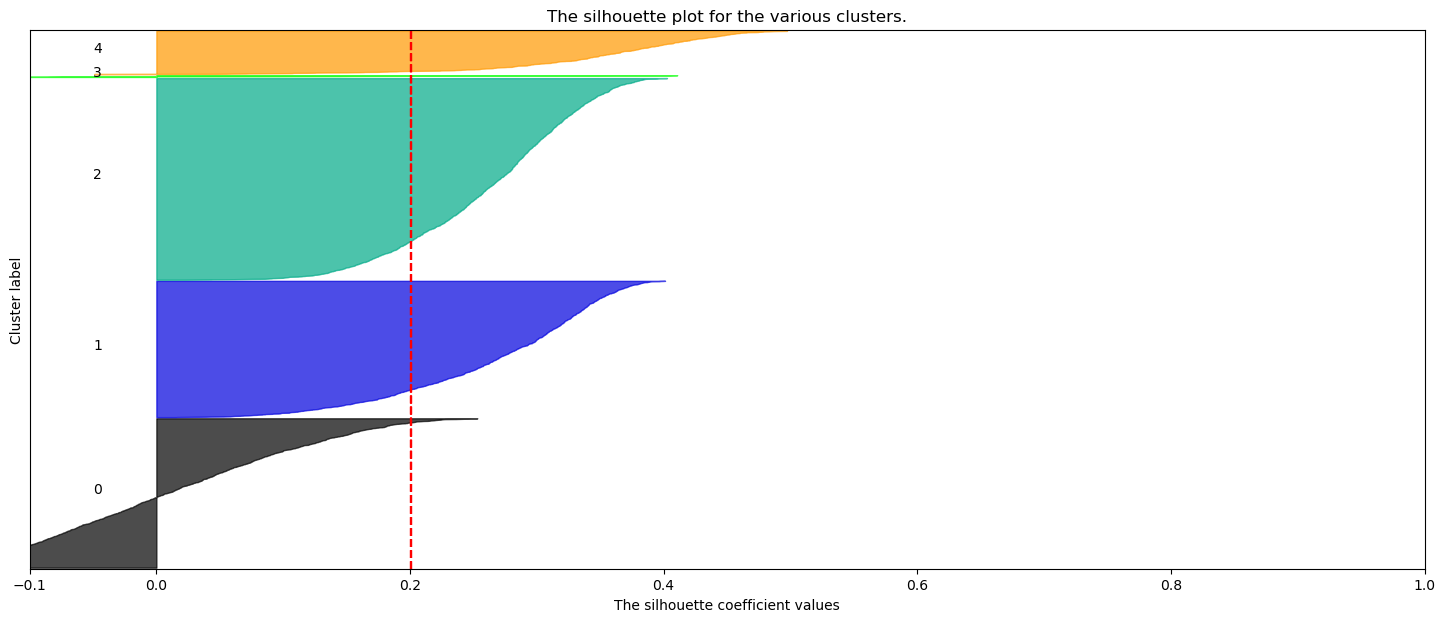

In [50]:
show_silhouette_plots(df_encoded_scaled, kmeans.labels_)

From the above silhouette plot, we can get some insights about our clustering:
- For cluster 0: Half of the observations are closer to another group.
- For cluster 1: All observations are closer to the cluster than the other clusters. Only a few observations have a lower silhouette score than the average silhouette score.
- For cluster 2: All observations are closer to the cluster than the other clusters. Only a few observations have silhouette scores lower than the average silhouette score.
- For cluster 3: This is the cluster of outliers.
- For cluster 4: Only a few observations have negative silhouette scores because one of the observations in Cluster 3 is actually very close to Cluster 4, so the silhouette scores for these observations are negative.

#### 8.4.3 KNN Distance Plot

In addition, the sparsity of the clustering can be checked by KNN distance plot.

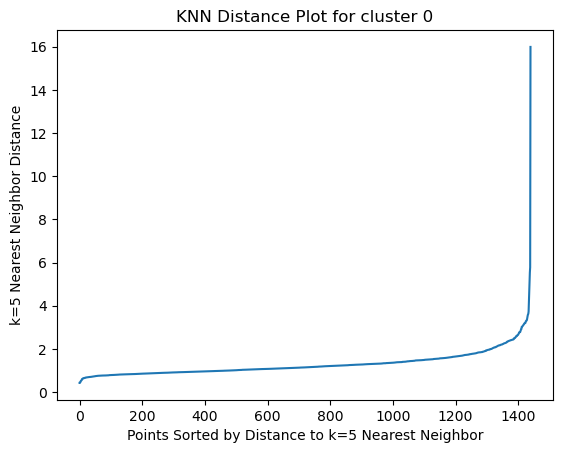

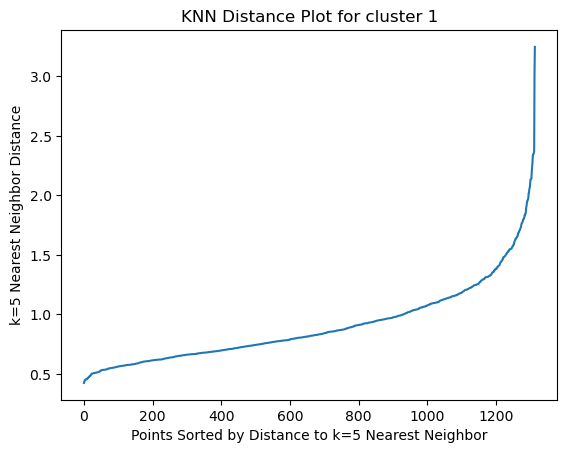

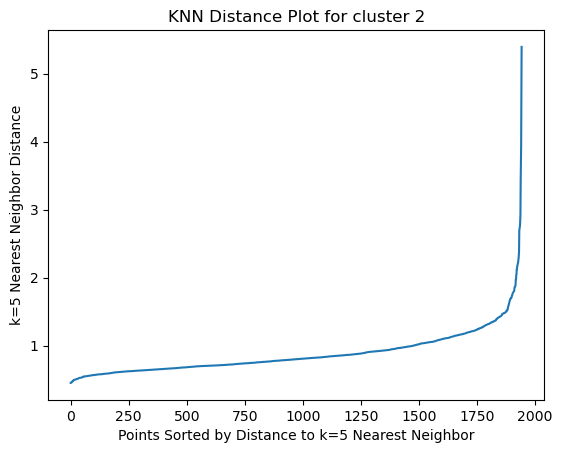

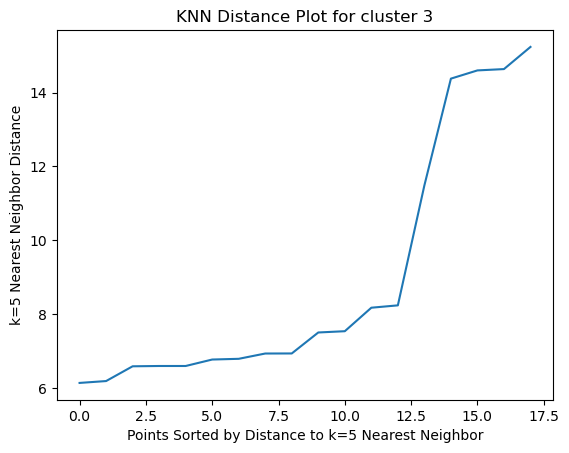

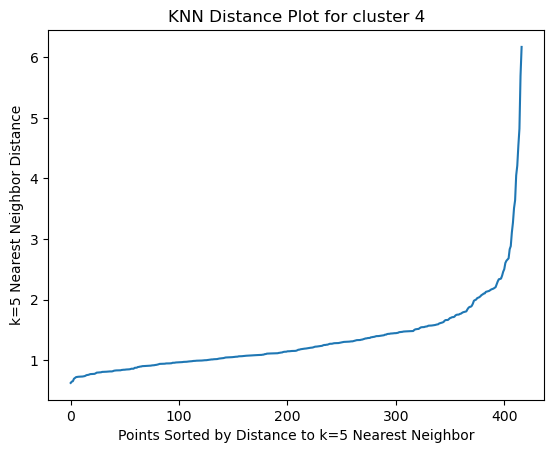

In [51]:
k = 5

for i in range(5):
    df_cluster = df_encoded_scaled_w_label[df_encoded_scaled_w_label['predicted_label'] == i]
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(df_cluster)
    distances, indices = nbrs.kneighbors(df_cluster)

    plt.plot(np.sort(distances.T[k-1]))
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('KNN Distance Plot for cluster %s'%i)
    plt.show()

For KNN distance plot for each cluster, only cluster 3 looks sparse, this corresponds to our findings in previous sections that observations in cluster 3 are scattered all over the place

#### 8.4.4 Shortcomings

Based on what we have so far, we believe that the cluster-sorted similarity matrix is not suitable for use with this dataset. Since the sub-clusters in each main cluster are close to each other, we see only a grid of all low similarity and therefore it is not as informative as a silhouette plot.

### 8.5 Finding the "Inherent" Clusters

Let's recall our cluster color-code t-SNE plot:

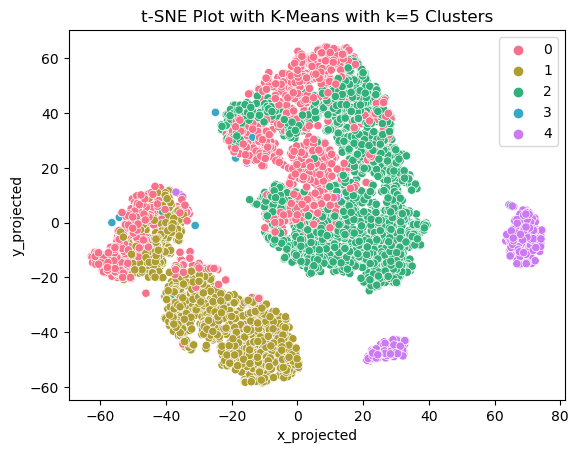

In [52]:
sns.scatterplot(x='x_projected',y='y_projected', hue=df_encoded_scaled_w_label['predicted_label'], palette=sns.color_palette("husl", k), data=df_combo)
plt.title('t-SNE Plot with K-Means with k=%s Clusters' %(k))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

The clustering produced by k-means splits some "inherent" large clusters. For example, the left-most cluster is splitted by both observations with cluster lable 0 and cluster label 1. And the middle cluster is splitted by observations with cluster label 0 and cluster label 2.

In addition, this clustering "merges" two "inherent" clusters. The clusters labeled in purple in the t-SNE plot were two "inherent" small clusters. This is reasonable, because in the t-SNE plot that color-coded by "Diagnosis" label, these two small clusters are comprised of observations with diabetes.

### 8.6 Post Cluster Analysis

Finally, we can do some post clustering analysis by describing what type of attribute values and attribute relationships characterize each of the resulting clusters in our final clustering. We will create side-by-side boxplots and bar plots to visualize each attributes and its clustering.

Before we actually make the side-by-side boxplots and barplots, we need to unscale and unencode our dataset to better show the clustering effect. Since we already have the copy of the unscaled and unencoded version, we can simply move the predicted_label to that copy.

In [53]:
df['predicted_label'] = df_encoded_scaled_w_label['predicted_label']
df

Age Gender  BMI  Chol    TG   HDL   LDL    Cr   BUN  Diagnosis  \
0      50      F   24  4.20  0.90  2.40  1.40  46.0  4.70          0   
1      26      M   23  3.70  1.40  1.10  2.10  62.0  4.50          0   
2      33      M   21  4.90  1.00  0.80  2.00  46.0  7.10          0   
3      45      F   21  2.90  1.00  1.00  1.50  24.0  2.30          0   
4      50      F   24  3.60  1.30  0.90  2.10  50.0  2.00          0   
...   ...    ...  ...   ...   ...   ...   ...   ...   ...        ...   
5127   54      M   23  5.00  1.50  1.24  2.98  77.0  3.50          1   
5128   50      F   22  4.37  2.09  1.37  2.29  47.3  4.40          1   
5129   67      M   24  3.89  1.38  1.14  2.17  70.6  4.73          1   
5130   60      F   29  5.91  1.29  1.73  2.85  50.2  7.33          1   
5131   37      M   34  5.42  2.66  1.08  2.87  75.5  4.61          1   

      predicted_label  
0                   1  
1                   2  
2                   2  
3                   1  
4                   1  
...               ...  
5127                2  
5128                1  
5129                2  
5130                0  
5131                0  

[5132 rows x 11 columns]

#### 8.6.1 Numerical Attribute

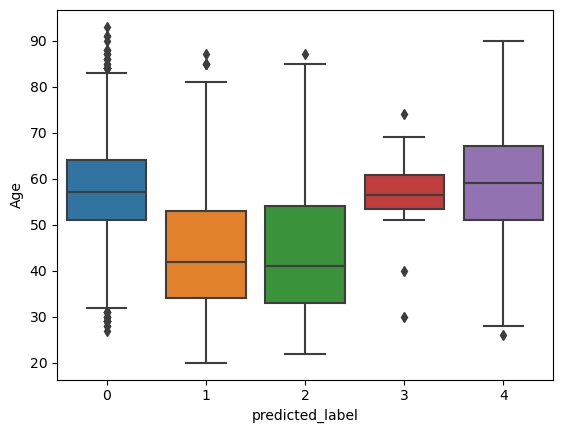

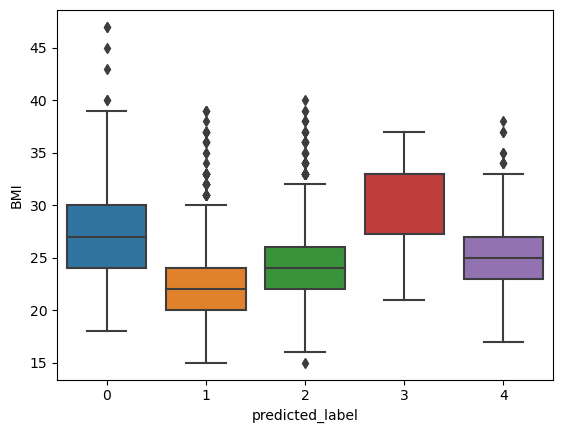

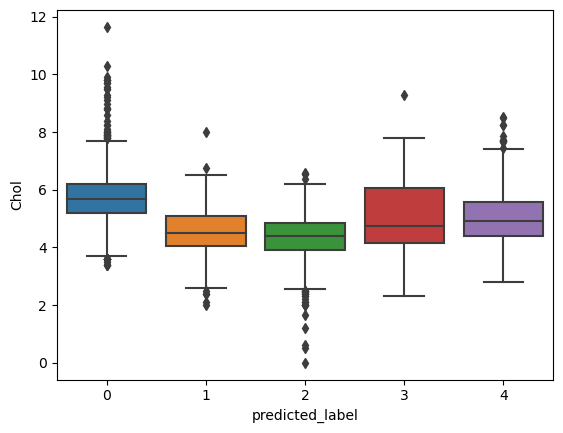

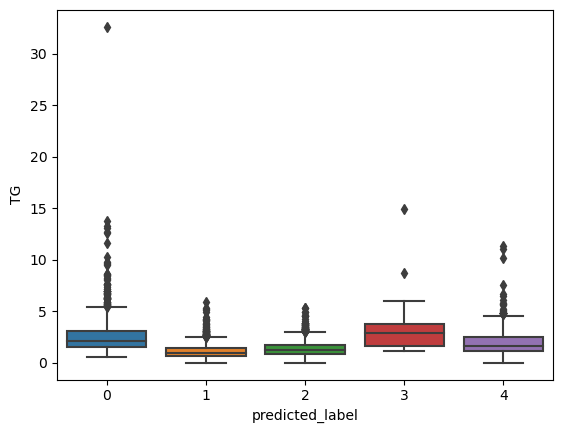

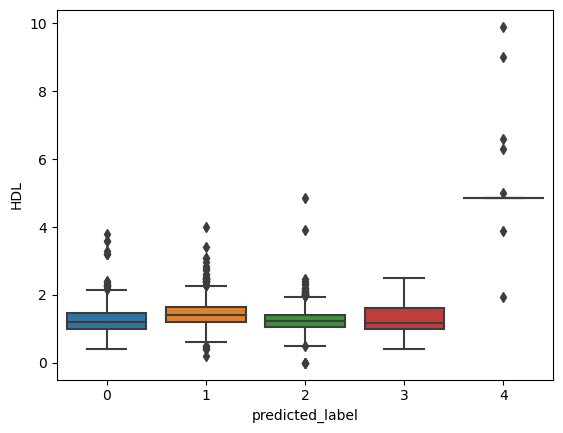

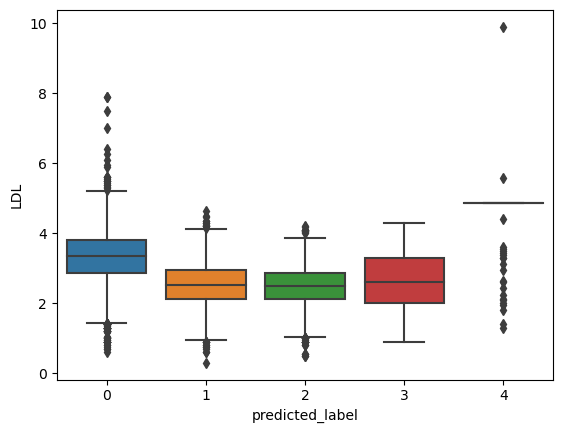

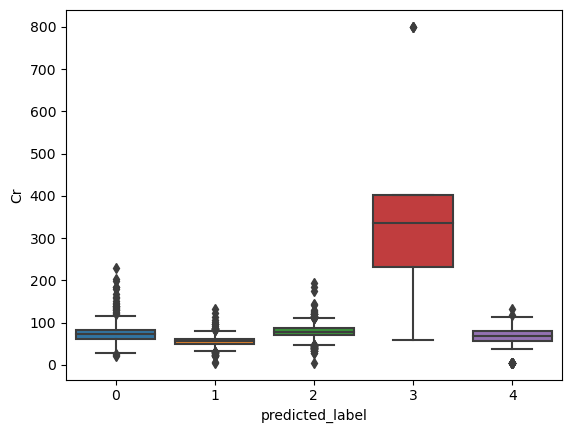

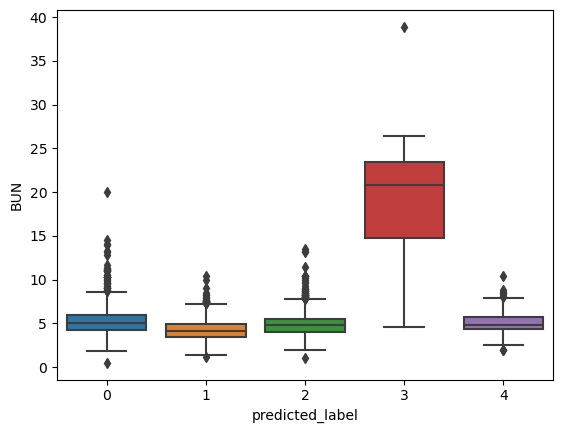

In [54]:
for col in df.columns[:9]:
    if col == "Gender":
        continue
    sns.boxplot(x="predicted_label", y=col, data=df)
    plt.show()

- Most of the people in cluster 0 were older with high levels of BMI, Chol, TG and LDL and moderate levels of HDL, Cr and BUN.
- Most of the people in cluster 1 were of moderate age with low levels of BMI, TG, Cr, LDL and BUN and moderate levels of cholesterol and HDL.
- Most of the people in cluster 2 were of moderate age with moderate BMI, Cr and BUN and low cholesterol, TG, HDL and LDL.
- Most of the people in cluster 3 were older and had higher levels of BMI, TG, Cr and BUN and moderate levels of cholesterol, HDL and LDL.
- The majority of people in cluster 4 were older, had higher levels of HDL and LDL, moderate levels of BMI, cholesterol, Cr and BUN, and lower levels of TG.

#### 8.6.2 Categorical Attribute

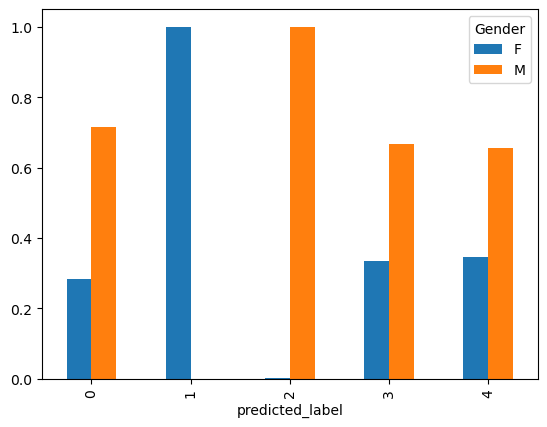

In [55]:
ctab=pd.crosstab(df['predicted_label'], df['Gender'], normalize='index')
ctab.plot.bar()
plt.show()

- Cluster 0: The majority are men, with fewer women.
- Cluster 1: predominantly female.
- Cluster 2: predominantly male.
- Cluster 3: The majority are male and fewer are female.
- Cluster 4: Mostly male, less female.

## 9. Clustering Algorithm 2

### 9.1 Parameter Selection  
For GMM, i need to select number of clusters k.

#### 9.1.1 AIC plot
The Akaike Information Criterion (AIC) can be used to achieve a balance of minimizing the number of clusters and maximizing the fit of the model. Here I use the plot of AICs to select number of clusters that minimize AIC value

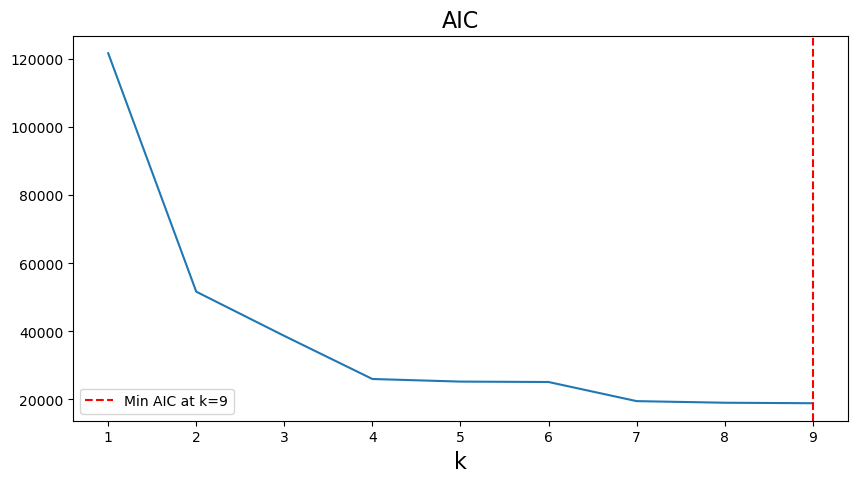

In [56]:
aics = []
X = df_encoded_scaled.copy()
K = 10
for k in range(1, K):
    #Fit the GMM model
    gm = GaussianMixture(n_components=k, random_state=100)
    gm.fit(X)
    
    aics.append(gm.aic(X))

#Plot these values
fig, ax = plt.subplots(1, 1, figsize=(10,5))
#AIC
ax.plot(range(1, K), aics)
ax.set_xticks(range(1, K))
ax.set_xlabel('k', fontsize=16)
ax.set_title('AIC', fontsize=16)

ax.axvline(x=np.argmin(aics)+1, color='red', linestyle='--', label=f'Min AIC at k={np.argmin(aics)+1}')
ax.legend()
plt.show()

from the AIC plot we can see that the AIC decreases much more gradual after k = 7. And the lowest AIC is at k = 9. So based on AIC plot, i will choose k = 9 clusters

#### 9.1.2 BIC plot
The Bayesian Information Criterion (BIC) is similar to AIC but it has stronger penalty on model complexity. I can also use BIC to help me select number of clusters. 

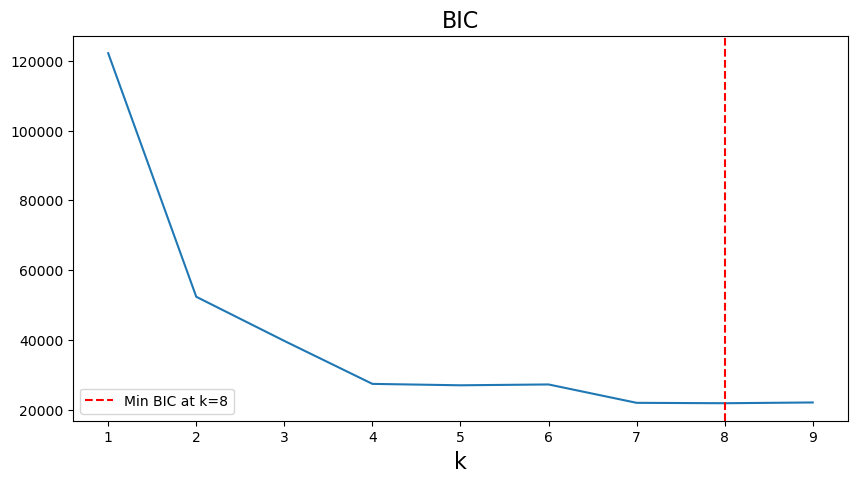

In [57]:
bics = []
X = df_encoded_scaled.copy()
K = 10
for k in range(1, K):
    #Fit the GMM model
    gm = GaussianMixture(n_components=k, random_state=100)
    gm.fit(X)
    bics.append(gm.bic(X))



#Plot these values

fig, ax = plt.subplots(1, 1, figsize=(10,5))
#BIC
ax.plot(range(1, K), bics)
ax.set_xticks(range(1, K))
ax.set_xlabel('k', fontsize=16)
ax.set_title('BIC', fontsize=16)

ax.axvline(x=np.argmin(bics)+1, color='red', linestyle='--', label=f'Min BIC at k={np.argmin(bics)+1}')
ax.legend()
plt.show()

from the BIC plot we can see that the BIC decreases much more gradual after k = 7. And the lowest BIC is at k = 8. So based on BIC plot, i will choose k = 8 clusters

AIC and BIC disagrees with the number of clusters, AIC suggests k = 9 and BIC suggests k = 8. Since the AIC values for k = 7, 8, 9 are very close and the smallest BIC value is at k = 8, i will choose 8 clusters.

### 9.2 Clustering the data

In [58]:
gm = GaussianMixture(n_components=8, random_state=100)
gm.fit(df_encoded_scaled)
W = gm.predict_proba(df_encoded_scaled)

cluster_columns=['Cluster %s Membership Score'%(str(i)) for i in range(0,8)]
df_membership=pd.DataFrame(W, columns=cluster_columns)
df_membership.round(4)

Cluster 0 Membership Score  Cluster 1 Membership Score  \
0                         0.0000                      0.2906   
1                         0.0000                      0.0000   
2                         0.0043                      0.0000   
3                         0.0000                      0.5840   
4                         0.0000                      0.9878   
...                          ...                         ...   
5127                      0.0002                      0.0000   
5128                      0.0000                      0.9591   
5129                      0.0007                      0.0000   
5130                      0.0000                      0.1530   
5131                      0.0083                      0.0000   

      Cluster 2 Membership Score  Cluster 3 Membership Score  \
0                         0.7094                         0.0   
1                         0.0000                         0.0   
2                         0.0000                         0.0   
3                         0.4160                         0.0   
4                         0.0122                         0.0   
...                          ...                         ...   
5127                      0.0000                         0.0   
5128                      0.0409                         0.0   
5129                      0.0000                         0.0   
5130                      0.8470                         0.0   
5131                      0.0000                         0.0   

      Cluster 4 Membership Score  Cluster 5 Membership Score  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
5127                         0.0                         0.0   
5128                         0.0                         0.0   
5129                         0.0                         0.0   
5130                         0.0                         0.0   
5131                         0.0                         0.0   

      Cluster 6 Membership Score  Cluster 7 Membership Score  
0                         0.0000                      0.0000  
1                         0.0049                      0.9951  
2                         0.9956                      0.0000  
3                         0.0000                      0.0000  
4                         0.0000                      0.0000  
...                          ...                         ...  
5127                      0.0149                      0.9849  
5128                      0.0000                      0.0000  
5129                      0.0088                      0.9905  
5130                      0.0000                      0.0000  
5131                      0.8464                      0.1454  

[5132 rows x 8 columns]

### 9.3 Clustering Algorithm Results Presentation

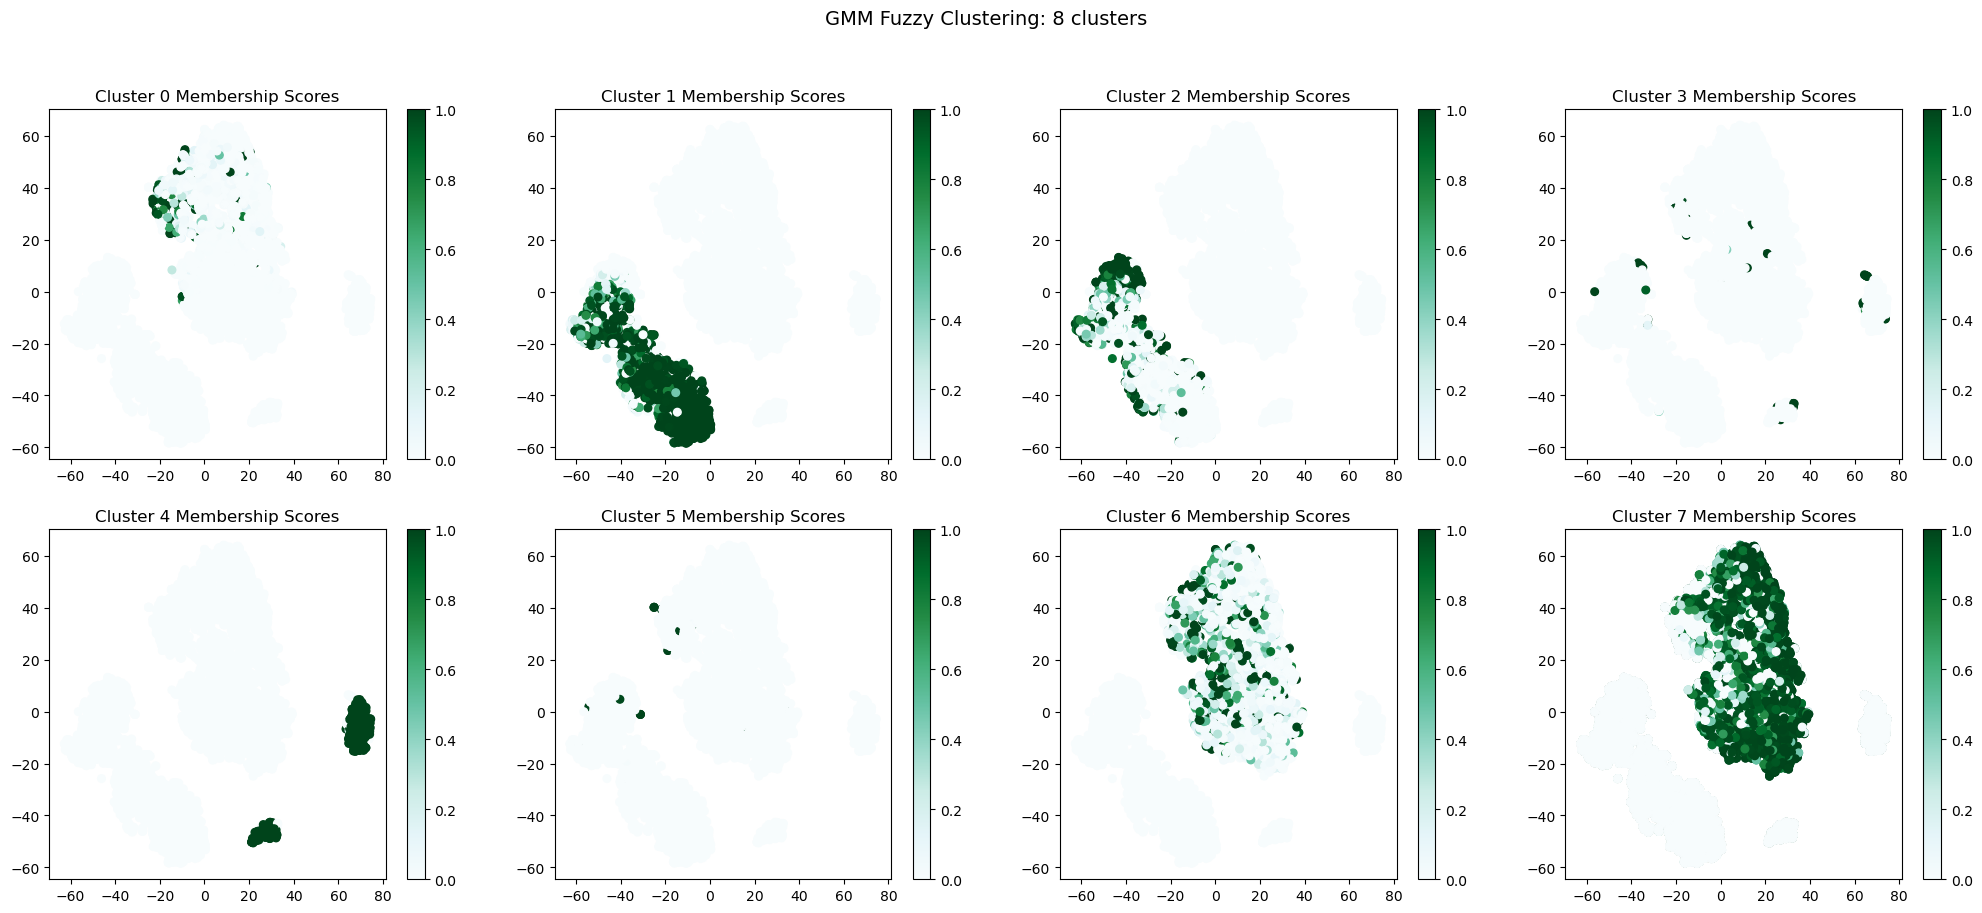

In [59]:
df_scaled_w_mem_score = df_encoded_scaled_w_label.copy()
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
plt.suptitle('GMM Fuzzy Clustering: %s clusters'%(8), fontsize=14)
for i in range(8):

    #Create a column with cluster i membership scores
    df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)]=df_membership['Cluster %s Membership Score'%(str(i))]

    #Plot the points, color coded by the membership score.
    points = plt.scatter(df_combo["x_projected"], df_combo["y_projected"],
                 c=df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)],
                         s=30, cmap="BuGn",
                        vmin=0,
                        vmax=1)
    ax[int(np.floor(i/4)),int(i%4)].scatter(df_combo["x_projected"], df_combo["y_projected"],
                 c=df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)],
                                            s=30, cmap="BuGn",
                                           vmin=0,
                                           vmax=1)

    fig.colorbar(points, ax=ax[int(np.floor(i/4)),int(i%4)])
    ax[int(np.floor(i/4)),int(i%4)].set_title('Cluster %s Membership Scores'%(str(i)))
plt.show()

In [60]:

membership_columns = [col for col in df_scaled_w_mem_score.columns if 'Membership Score' in col]
df_scaled_w_mem_score['predicted_cluster'] = df_scaled_w_mem_score[membership_columns].idxmax(axis=1).str.extract('(\d+)')[0].astype(int)

cluster_summary = df_scaled_w_mem_score.groupby('predicted_cluster')['Diagnosis'].agg(['sum', 'count'])
cluster_summary['percentage_diagnosed'] = (cluster_summary['sum'] / cluster_summary['count']) * 100
print(cluster_summary[['sum','count','percentage_diagnosed']])


                   sum  count  percentage_diagnosed
predicted_cluster                                  
0                  155    172             90.116279
1                  298   1302             22.887865
2                  308    418             73.684211
3                   33     40             82.500000
4                  391    391            100.000000
5                   19     22             86.363636
6                  254    591             42.978003
7                  535   2196             24.362477


- From the t-sne plot, we can see that the number of observations for each cluster varies a lot. Cluster 0, 3, 5 have much less obeservations than other clusters, from the table we can see that cluster 90% patients who have highest membership score in cluster 0 are diagnosed, and 82% for cluster 3, 86% for cluster 5. Patients from these clusters probably have elevated indicators that contribute to diabetes. Besides that, GMM identifies patients who have highest membership score in cluster 4 are 100% diagnoised having diabetes.  
- Based on the percentage_diagnosed we calculated, each cluster has very different percent of being diagnosed of diabetes. Among all clusters, cluster 0, 2, 3, 4, 5 have much higher percentage of being diagnosed. Those clusters varies a lot in terms of number of observations and different cluster shape, and patients from each cluster are likely to have different underlying causes of diabetes. Doctors and students studying medical care could explore this insight to help them create better and more personalized plans for tests and treatments.

### 9.4 Additional Cluster Exploration

#### 9.4.1 Cluster-Sorted Similarity Matrix

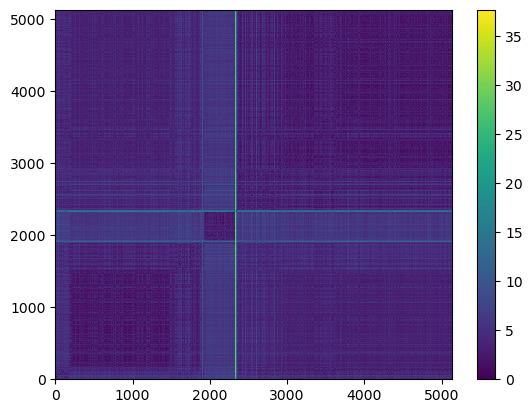

In [61]:
df_sorted = df_scaled_w_mem_score.copy()
df_sorted.drop(membership_columns, axis = 1, inplace = True)
df_sorted = df_sorted.sort_values(by = ["predicted_cluster"])
df_sorted.drop(["Diagnosis", "predicted_cluster"], axis = 1, inplace = True)
dist_matrix = squareform(pdist(df_sorted))

plt.pcolormesh(dist_matrix)
plt.colorbar()
N = len(df_sorted)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

From the cluster sorted similarity matrix,  can see that only cluster 4 [1932 - 2323] is comparatively distant from other clusters and other clusters are not well seperated.

#### 9.4.2 Silhouette Plot

For n_clusters = 8 The average silhouette_score is : 0.17806411269115


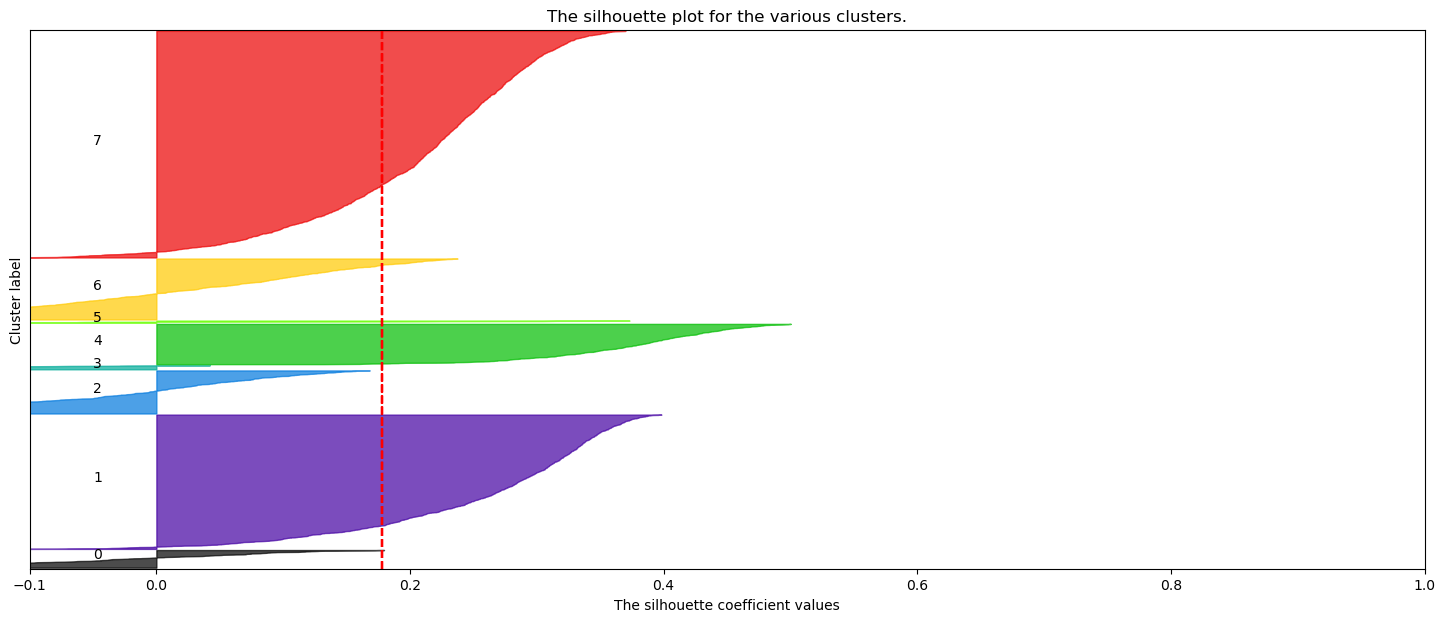

In [62]:
show_silhouette_plots(df_encoded_scaled, df_scaled_w_mem_score['predicted_cluster'].array)

- Cluster 0 is not cohesive, about half observations are closer to other cluster
- cluster 1 is relatively cohesive, only small amout of observations have negative silhouette score, and it has relatively large average silhouette scores comaring to other clusters
- cluster 2 is not cohesive, about half observations are closer to other cluster
- cluster 3 is the least cohesive, most observations are closer to other cluster
- cluster 4 is very cohesive, every observation from cluster 4 has positive silouette score. And cluster 4 has the highest average silhouette score among all clusters
- cluster 5 is not cohesive, about half observations are closer to other cluster
- cluster 6 is not cohesive, about half observations are closer to other cluster
- cluster 7 is relatively cohesive, only few observations have negative silhouette score, and it has relatively large average silhouette scores comaring to other clusters


#### 9.4.3 KNN Distant Plot

In [63]:
df_temp = df_scaled_w_mem_score.copy()
df_temp.drop(membership_columns, axis = 1, inplace = True)
df_temp.drop(["Diagnosis"], axis = 1, inplace = True)
df_temp

Age    Gender       BMI      Chol        TG       HDL       LDL  \
0     0.074725 -1.317425 -0.143427 -0.666247 -0.617462  0.776604 -1.601683   
1    -1.633774  0.759057 -0.377247 -1.165770 -0.240652 -0.474903 -0.861202   
2    -1.135462  0.759057 -0.844888  0.033086 -0.542100 -0.763712 -0.966985   
3    -0.281213 -1.317425 -0.844888 -1.965007 -0.542100 -0.571173 -1.495900   
4     0.074725 -1.317425 -0.143427 -1.265675 -0.316014 -0.667443 -0.861202   
...        ...       ...       ...       ...       ...       ...       ...   
5127  0.359474  0.759057 -0.377247  0.132991 -0.165290 -0.340126  0.069689   
5128  0.074725 -1.317425 -0.611067 -0.496409  0.279346 -0.214975 -0.660214   
5129  1.284911  0.759057 -0.143427 -0.975951 -0.255724 -0.436395 -0.787154   
5130  0.786599 -1.317425  1.025675  1.042123 -0.323550  0.131596 -0.067829   
5131 -0.850712  0.759057  2.194776  0.552590  0.708910 -0.494157 -0.046672   

            Cr       BUN  predicted_label  predicted_cluster  
0    -0.882533 -0.116616                1                  2  
1    -0.320965 -0.235026                2                  7  
2    -0.882533  1.304309                2                  6  
3    -1.654690 -1.537540                1                  1  
4    -0.742141 -1.715156                1                  1  
...        ...       ...              ...                ...  
5127  0.205506 -0.827078                2                  7  
5128 -0.836906 -0.294231                1                  1  
5129 -0.019121 -0.098854                2                  7  
5130 -0.735121  1.440481                0                  2  
5131  0.152859 -0.169901                0                  6  

[5132 rows x 11 columns]

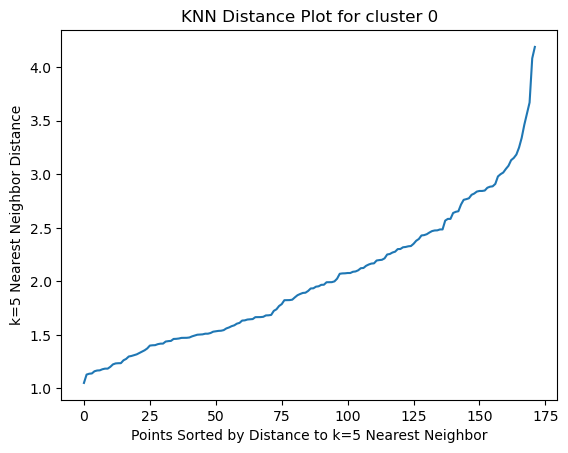

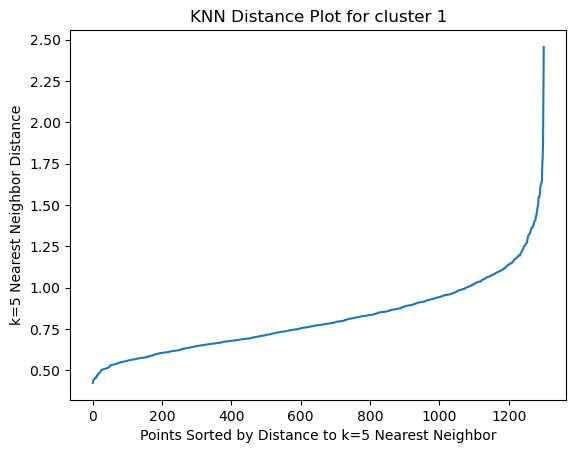

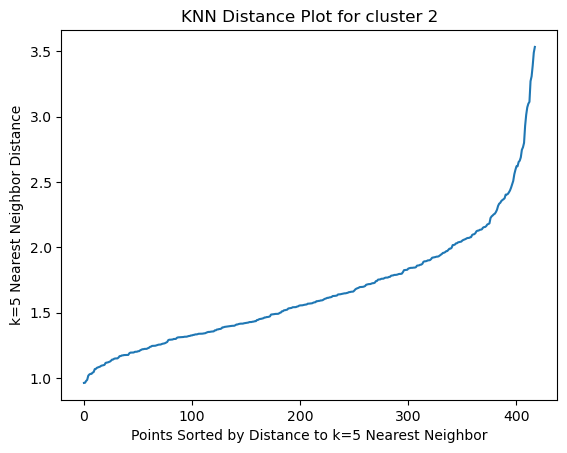

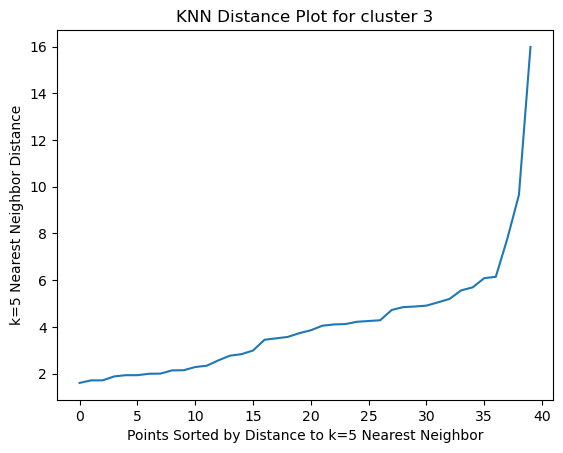

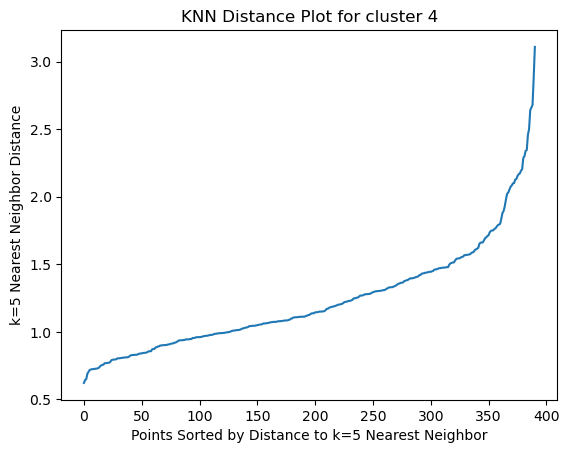

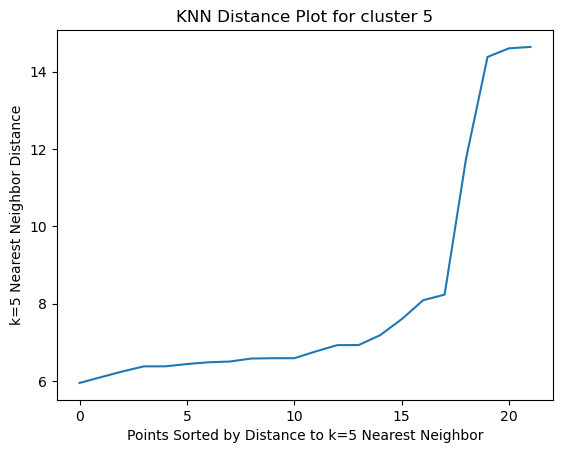

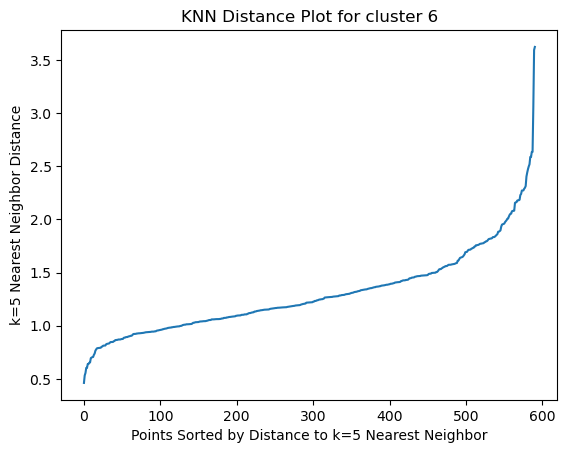

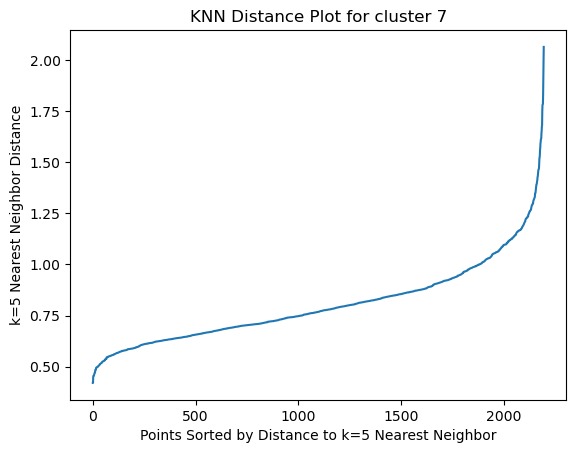

In [64]:
k = 5
for i in range(8):
    df_cluster = df_temp[df_temp["predicted_cluster"] == i]
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(df_cluster)
    distances, indices = nbrs.kneighbors(df_cluster)

    plt.plot(np.sort(distances.T[k-1]))
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('KNN Distance Plot for cluster %s'%i)
    plt.show()

From KNN distance plot for each cluster, we can see that cluster 3 and cluster 5 are more sparse than others

#### 9.4.4 Shortcomings
Based on what we have so far, we believe that the cluster-sorted similarity matrix is not suitable for use with this dataset. Since the sub-clusters in each main cluster are close to each other, we see only a grid of all low similarity and therefore it is not as informative as a silhouette plot.

### 9.5 Finding the "Inherent" Clusters

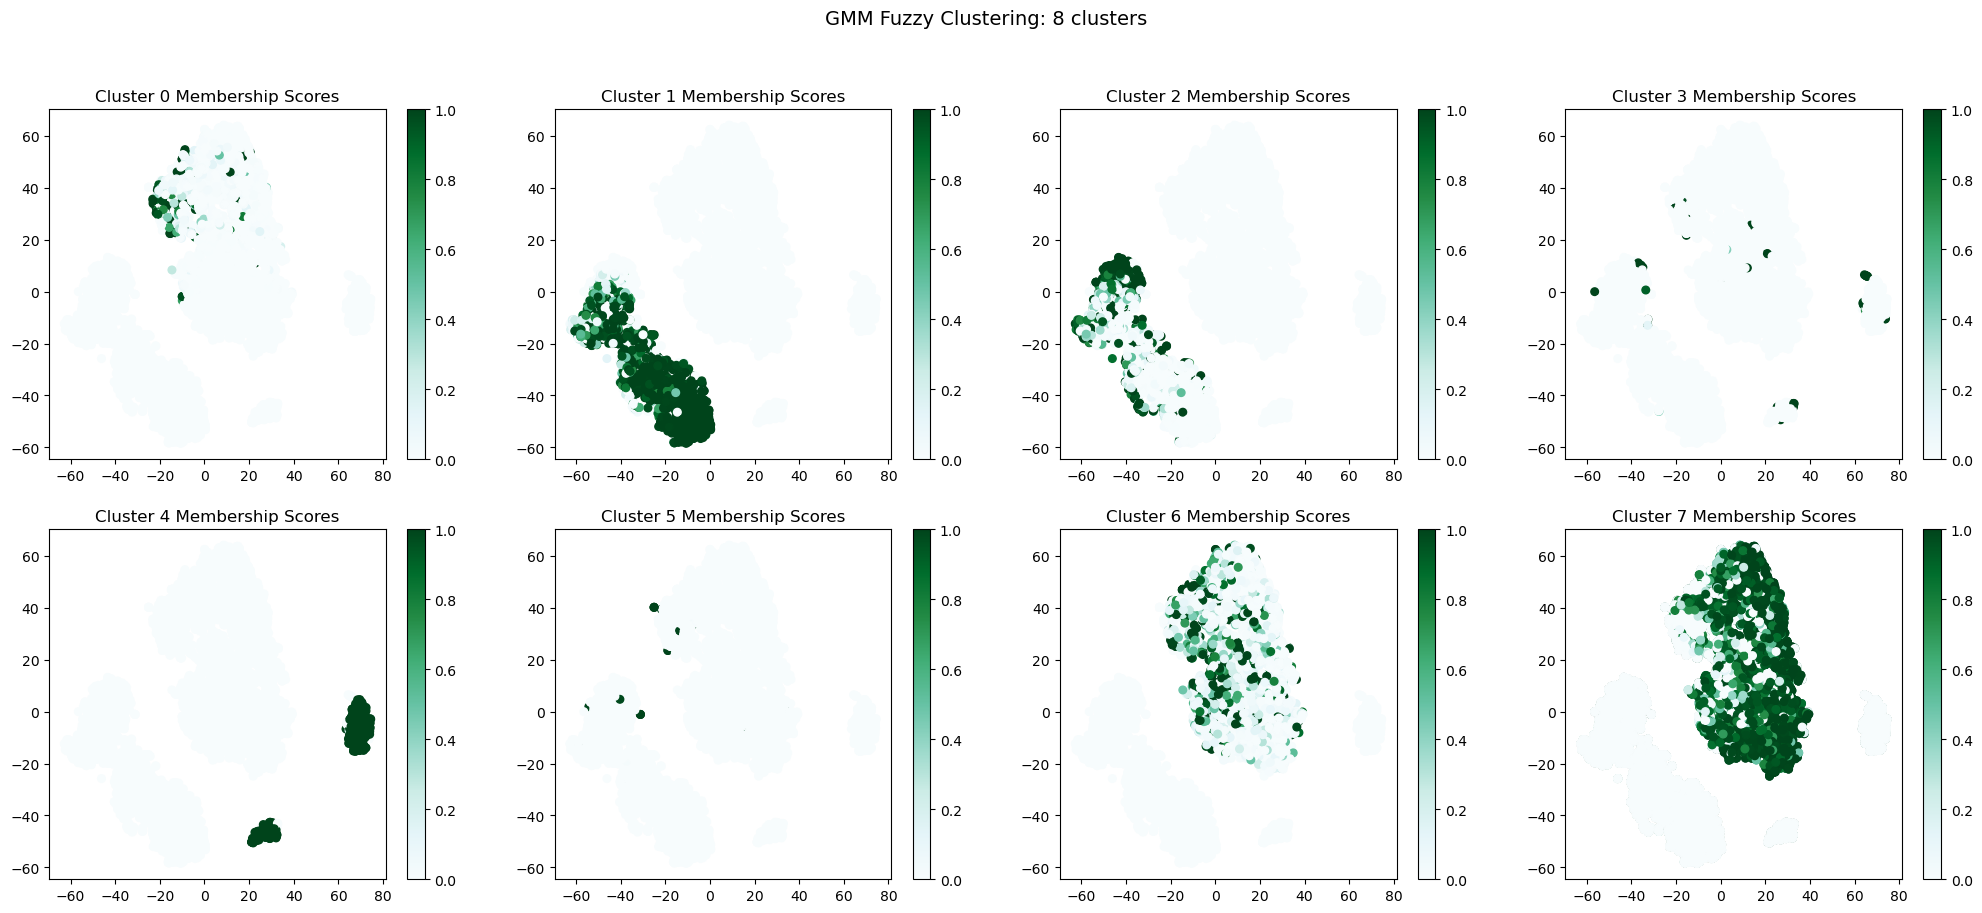

In [65]:
df_scaled_w_mem_score = df_encoded_scaled_w_label.copy()
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
plt.suptitle('GMM Fuzzy Clustering: %s clusters'%(8), fontsize=14)
for i in range(8):

    #Create a column with cluster i membership scores
    df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)]=df_membership['Cluster %s Membership Score'%(str(i))]

    #Plot the points, color coded by the membership score.
    points = plt.scatter(df_combo["x_projected"], df_combo["y_projected"],
                 c=df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)],
                         s=30, cmap="BuGn",
                        vmin=0,
                        vmax=1)
    ax[int(np.floor(i/4)),int(i%4)].scatter(df_combo["x_projected"], df_combo["y_projected"],
                 c=df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)],
                                            s=30, cmap="BuGn",
                                           vmin=0,
                                           vmax=1)

    fig.colorbar(points, ax=ax[int(np.floor(i/4)),int(i%4)])
    ax[int(np.floor(i/4)),int(i%4)].set_title('Cluster %s Membership Scores'%(str(i)))
plt.show()

- there is evidence to suggest that our clustering "split" one of the "inherent" clusters that exists in this dataset. From the t-sne plot, cluster 1 and cluster 2 are probably splited from one large inherent cluster, and cluster 6 and cluster 7 are probably splited from one parge inherent cluster.
- there is evidence to suggest that one of the clusters in our clustering contains two or more of the "inherent" clusters that exists in this dataset. In cluster 4's plot, we can see there are two ellipsoidal shaped inherent clusters that have meaningful seperation but are clustered into one big cluster.

### 9.6 Describing Each of the Clusters 

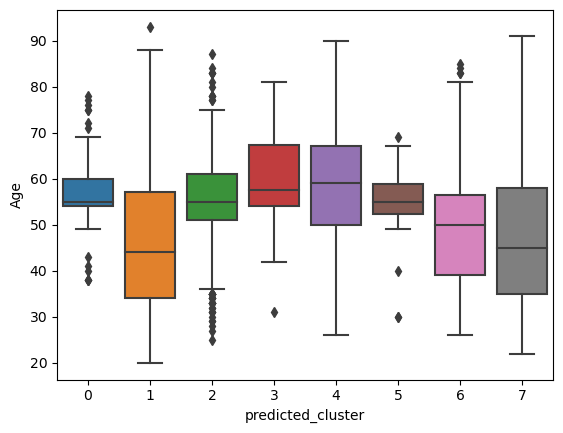

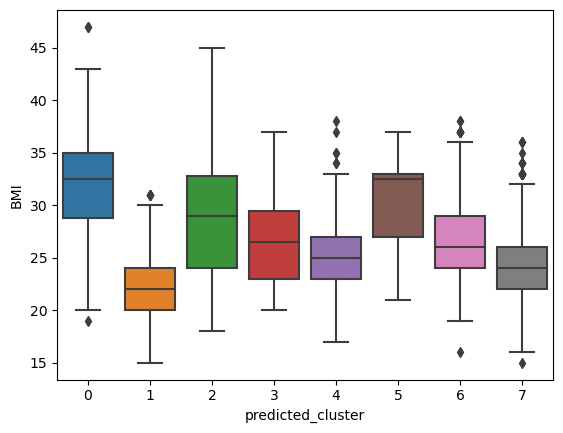

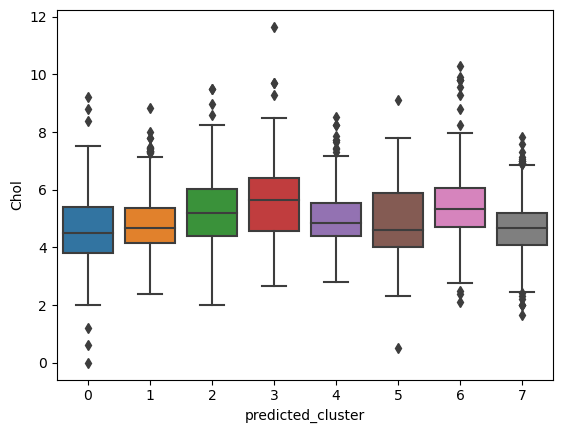

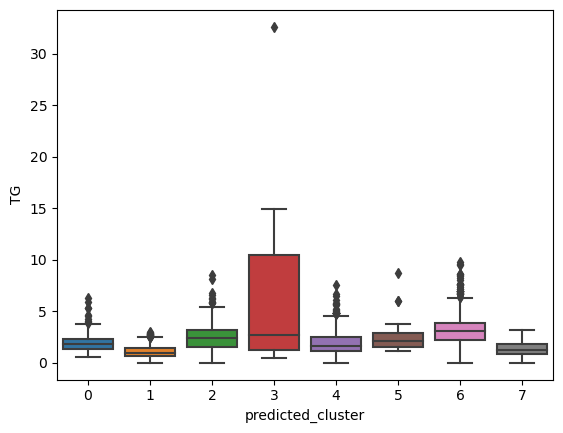

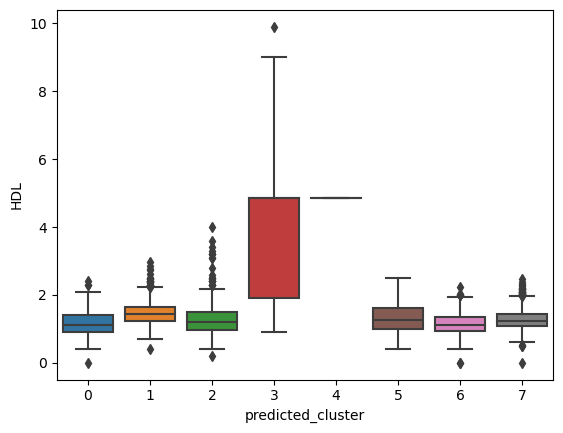

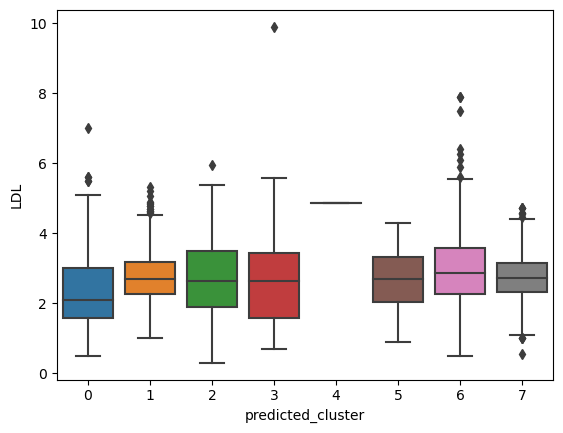

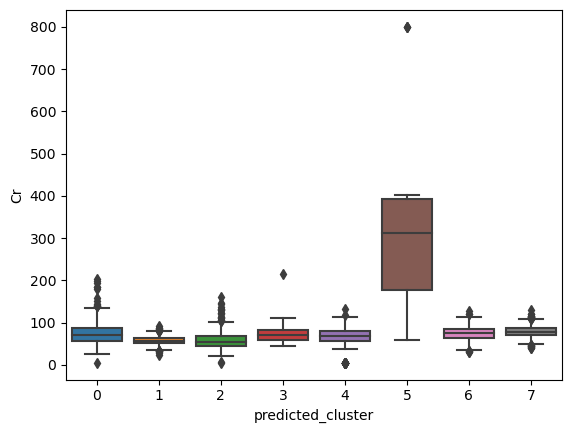

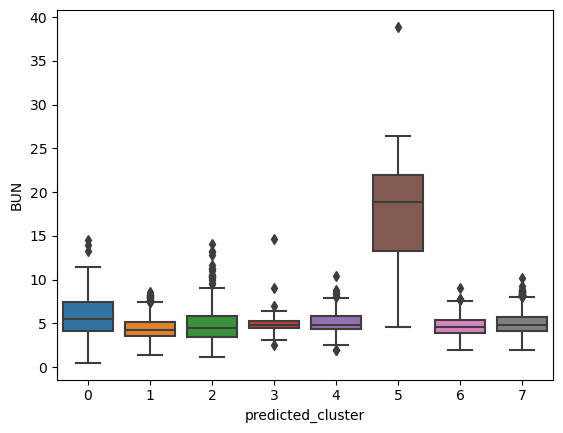

In [66]:
df_scaled_w_mem_score['predicted_cluster'] = df_scaled_w_mem_score[membership_columns].idxmax(axis=1).str.extract('(\d+)')[0].astype(int)
df["predicted_cluster"] = df_scaled_w_mem_score['predicted_cluster']

for col in df.columns[:9]:
    if col == "Gender":
        continue
    sns.boxplot(x="predicted_cluster", y=col, data=df)
    plt.show()


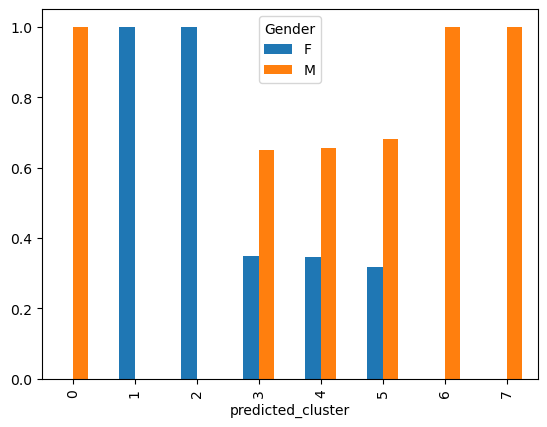

In [78]:
ctab=pd.crosstab(df['predicted_cluster'], df['Gender'], normalize='index')
ctab.plot.bar()
plt.show()

Based on the bar plots,

- People from cluster 0 are male who are relatively older and have the highest BMI median. (90% diagnosed)
- People from cluster 1 are female and the youngest and have the lowest BMI. (23% diagnosed)
- People from cluster 2 are female and they have a higher BMI compared to those from clusters with a low rate of diabetes, and many observations in cluster 2 show very high HDL. (73% diagnosed)
- cluster 3 have more male than female and people from cluster 3 have the second-highest age and the lowest BMI among clusters with a high rate of diabetes; they also have very extreme TG and HDL levels. (82% diagnosed)
- cluster 4 have more male than female and People from cluster 4 have the highest age and the lowest BMI, as well as the highest HDL and LDL medians. (100% diagnosed)
- cluster 5 have more male than female and People from cluster 5 have the highest BMI, highest Cr, and highest BUN. (86% diagnosed)
- People from cluster 6 are male who have relatively low age and BMI, and other body indicators are not extreme. (45% diagnosed)
- People from cluster 7 are male and they also have relatively low age and BMI, and other body indicators are not extreme. (24% diagnosed)


Overall, based on the clustering and bar plots, each cluster with a high likelihood of diabetes displays different gender and different combinations of problematic body indicators leading to diabetes. For example, in cluster 0, those are males who have diabetes and age and BMI are the major contributors. In cluster 2, those are female who have diabetes and BMI and HDL are the major contributors. For cluter 3, 4, and 5, there are mix of two genders. In cluster 3, age, TG, and HDL are the major contributors. In cluster 4, age, HDL, and LDL are the major contributors. In cluster 5, BMI, Cr, and BUN are are the major contributors.



## 10. Discussion

### 10.1 Clustering Similarities and  Differences

The results of these two clustering algorithms are roughly similar. For the first algorithm, we used K-Means to cluster the dataset with k = 5; while for the second algorithm, we used GMM to cluster the dataset with k = 8. Even we have different number of clusterings, there are still some inherent similarities between two methods. For example, The cluster 4 and 5 in the GMM displays the same behaviors as the cluster 3 in the K-Means method. As shown in the adjusted rand score, these two methods have a score of 0.5, meaning an accepteable similarities between the two methods. Additionally, as shown in the two color coded t-SNE plots below, some clusterings of observations are different in the two methods. For example, the cluster 0 in the K-Means method were separated to two clusters as 2 and 6 in the GMM method. 

In [75]:
adjusted_rand_score(df["predicted_label"], df["predicted_cluster"])

0.5046397464848349

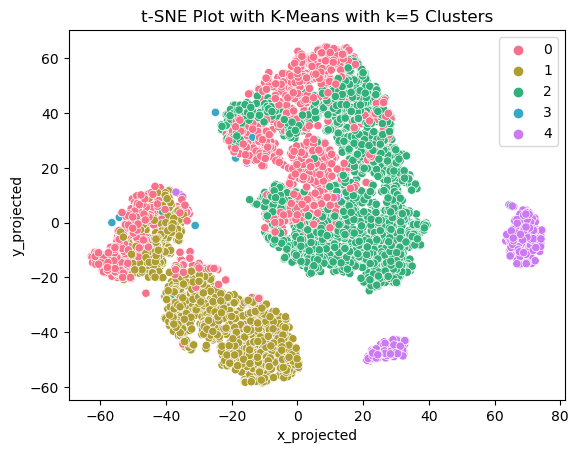

In [73]:
sns.scatterplot(x='x_projected',y='y_projected', hue=df_encoded_scaled_w_label['predicted_label'], palette=sns.color_palette("husl", 5), data=df_combo)
plt.title('t-SNE Plot with K-Means with k=%s Clusters' %(5))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

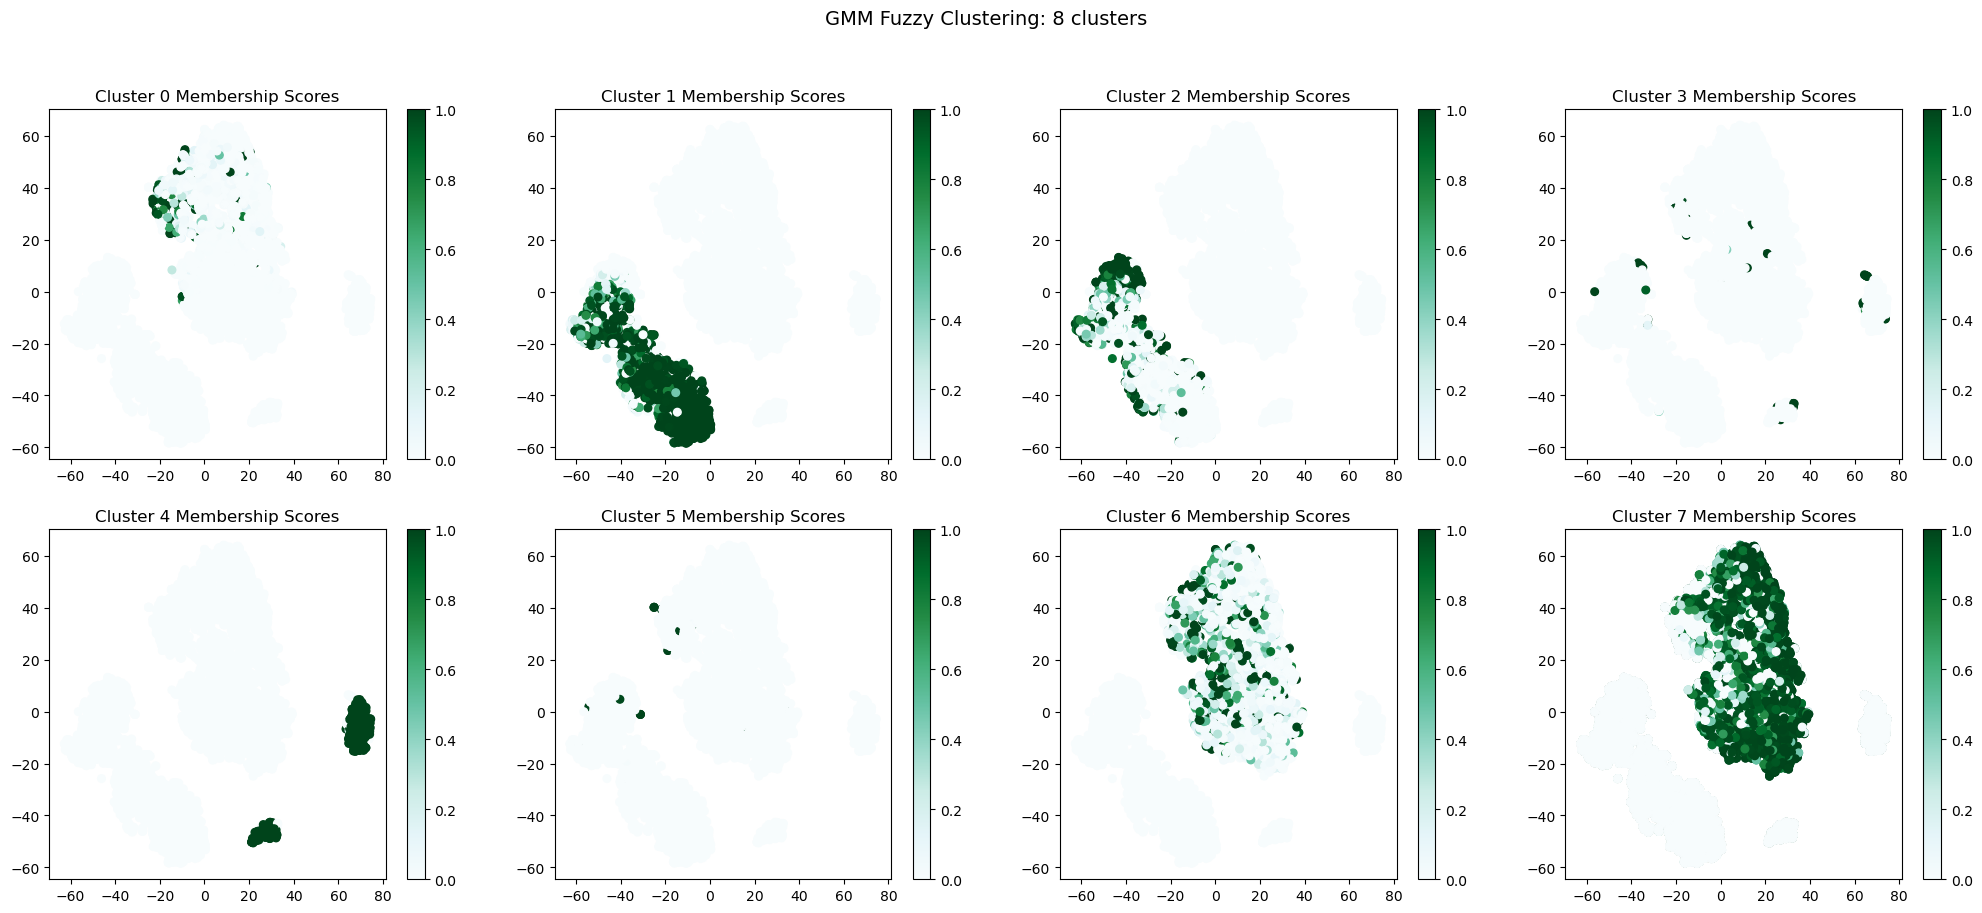

In [74]:
df_scaled_w_mem_score = df_encoded_scaled_w_label.copy()
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
plt.suptitle('GMM Fuzzy Clustering: %s clusters'%(8), fontsize=14)
for i in range(8):

    #Create a column with cluster i membership scores
    df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)]=df_membership['Cluster %s Membership Score'%(str(i))]

    #Plot the points, color coded by the membership score.
    points = plt.scatter(df_combo["x_projected"], df_combo["y_projected"],
                 c=df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)],
                         s=30, cmap="BuGn",
                        vmin=0,
                        vmax=1)
    ax[int(np.floor(i/4)),int(i%4)].scatter(df_combo["x_projected"], df_combo["y_projected"],
                 c=df_scaled_w_mem_score['Cluster %s Membership Score'%str(i)],
                                            s=30, cmap="BuGn",
                                           vmin=0,
                                           vmax=1)

    fig.colorbar(points, ax=ax[int(np.floor(i/4)),int(i%4)])
    ax[int(np.floor(i/4)),int(i%4)].set_title('Cluster %s Membership Scores'%(str(i)))
plt.show()

### 10.2 Clustering Performance

As shwon in the color coded t-SNE plot above, both of the two algorithms tend to separate the larger inherent clusterings and tend to merge the smaller clsuustering structs. However, even though these two methods didn't do well at identifying the inherent cluster strcuture, as shown in the t-SNE plot and the bar-plot above, they are able to identify meaningful clusterings based on other attributes.

### 10.3 Clustering Comparison:  Clustering Trustworthiness/Usefulness

We consider both clustering results to be reliable, as both are able to identify the majority of observations that have been diagnosed with diabetes. For instance, in k-means clustering, the majority of observations in clusters 0, 3, and 4 have been diagnosed with diabetes. Similarly, in GMM clustering, the majority of observations in clusters 0, 2, 3, 4, and 5 can be identified as those diagnosed with diabetes.

### 10.4 Clustering Comparion: Clustering Insights

Clustering 2 reveals insights about the data not evident in Clustering 1. In particular, Clustering 2 finds a group of observations exhibiting exceptionally high TG and HDL levels (referred to as Cluster 3 in Clustering 2). Additionally, clustering 2 identifies a group of observations that are mostly female and exhibit higher BMIs compared to those from clusters with a low prevalence of diabetes and high HDL levels (cluster 2 in clustering 2).

## 11. Conclusion

### 11.1 Summarization

In this project, we found a diabetes dataset to study impact of different body indicators on diabetes. We select all attributes from this dataset to analyze. We then did basic data cleaning and standard scaling to prepare for further cluster analysis. We use t-sne plot to show the inherent clusters of the dataset, which shows some obvious clustering structures. Based on the clutering structure, the first algorithm we used is k-means. We utilized elbow plot and average silhouette score plots to help us decide numebr of clusters. Then we color coded each cluster label in the t-SNE plot to visualize cluster result. And then use cluster-sorted similarity matrix, silhouette plot and KNN distance plot to assess seperation, cohesiveness and sparsity of clusters. Finally we used bar plot to visualize each cluster's attributes to do the post cluster analysis. The second cluster algorithm we used is GMM. We utilized AIC plot and BIC plot to help us decide number of clusters. Since this is a fuzzy clustering algorithm, we color coded t-SNE plot with cluster membership score to show cluster result. Then use cluster-sorted similarity matrix, silhouette plot and KNN distance plot to assess seperation, cohesiveness and sparsity of clusters. Finally we used bar plot to visualize each cluster's attributes to do the post cluster analysis. After clustering, we compared two cluster results. Both algorithm tend to separate large inherent clusters but they do generate meaningful clusterings based on t-SNE plot and bar plot. Also Both clusterings do reveal some insights that the other one don't have. We concluded that both clustering algorithms are troustworthy and useful.

### 11.2 Recommendation

I suggest that some of the insights that be extracted, according to the information we get from our analyze and the research motivation, those doctors work in the hospital will use our result. Because they will meet many diabetic every day, they can use these insights to identify specific risk factors in each cluster and create personalized care plans

The combinations in each category are the reasons why patients suffer from diabetes. For group 0, we should target the elderly with high BMI for intervention, because people who are heavier and older are more likely to develop diabetes. For the first group, young people with low body weight should be given relevant guidance, because early lifestyle changes can reduce the risk of diabetes. For the third and fourth groups, people are reminded to pay attention to some physical indicators, such as controlling the levels of TG and HDL with medication or diet, and at the same time making lifestyle changes for the elderly with high HDL and LDL indicators. The fifth group told us to address the effects of high BMI through medical consultation and diet. The sixth and seventh groups are prevention strategies for people with low BMI to cultivate their early health awareness.## References

### 11.3 Shortcomings

In our study, we standard-scaled all attributes and did not consider which attribute naturally have more weights. We did not experiment with different weight in scaling and see which one will give us better clustering result.  

We also treat gender as numerical attribute using 0,1 encoding in both of our algorithms. maybe we could get better and more informative clustering result when treating gender as categorical attribute and using algorithm that can deal with mix of numerical and categorical attributes.

### 11.4 Future Work

For future cluster analyze, people can try to do some supervised learning algorithm, such as decision trees, random forests or neural networks, to help people analyze physical conditions and predict diabetes risk.

Based on people's lifestyles, the medical system can investigate the impact of lifestyles on different groups and provide strategic guidance to different groups to help them better prevent diabetes. For some social organizations, they can carry out some health activities to popularize the harm of diabetes to the human body so that people can pay more attention to this type of disease.

## References

Green, A., & Gale, E. A. M. (1995). Diabetes The increasing burden. British Medical Journal, 
Retrieved from: https://pubmed.ncbi.nlm.nih.gov/8544677/

World Health Organization. Diabetes. WHO. 
Retrieved from: https://who.int/news-room/fact-sheets/detail/diabetes

European Commission. (2012, February 15). Diabetes. Health and Food Safety.
Retrieved from:
https: //health.ec.europa.eu/latest-updates/pages-diabetes-updated-2012-02-15_en

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=83d4967f-4eaf-4c09-a770-6d7ceb0a6ac8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>